In [1]:
import numpy as np
import pandas as pd

from malid import config, io, helpers
from malid.datamodels import healthy_label, GeneLocus, TargetObsColumnEnum
import gc
import joblib
from kdict import kdict
import itertools
import genetools
from pathlib import Path
from slugify import slugify
from typing import Tuple
import scanpy as sc

In [2]:
import matplotlib.pyplot as plt

%matplotlib inline
import seaborn as sns

In [3]:
def get_dirs(gene_locus: GeneLocus):
    output_dir = config.paths.model_interpretations_output_dir / gene_locus.name
    highres_output_dir = (
        config.paths.high_res_outputs_dir / "model_interpretations" / gene_locus.name
    )

    # Create directories - though these directories should already have been created by sequence model interpretations notebooks
    output_dir.mkdir(parents=True, exist_ok=True)
    highres_output_dir.mkdir(parents=True, exist_ok=True)

    return output_dir, highres_output_dir

# Compute V gene counts overall by disease cohort

Run once. Saved to disk and reloaded by later functions.

In [4]:
def get_vgene_and_cdr3length_counts(
    gene_locus: GeneLocus,
) -> Tuple[pd.DataFrame, pd.DataFrame]:
    fold_labels = ["train_smaller", "validation", "test"]

    specimen_v_gene_counts = []
    specimen_cdr3_length_counts = []
    for fold_id in config.all_fold_ids:
        for fold_label in fold_labels:
            if fold_id == -1 and fold_label == "test":
                # skip: global fold does not have a test set
                continue
            adata = io.load_fold_embeddings(
                fold_id=fold_id,
                fold_label=fold_label,
                gene_locus=gene_locus,
                target_obs_column=TargetObsColumnEnum.disease,
            )
            df = adata.obs
            for specimen_label, subset_obs in adata.obs.groupby(
                "specimen_label", observed=True
            ):
                v_gene_counts = (
                    subset_obs["v_gene"].cat.remove_unused_categories().value_counts()
                )
                cdr3_length_counts = subset_obs[
                    "cdr3_aa_sequence_trim_len"
                ].value_counts()
                specimen_description = subset_obs[["specimen_label", "disease"]].iloc[0]
                specimen_v_gene_counts.append(
                    {
                        "fold_id": fold_id,
                        "fold_label": fold_label,
                        **v_gene_counts.to_dict(),
                        **specimen_description.to_dict(),
                    }
                )
                specimen_cdr3_length_counts.append(
                    {
                        "fold_id": fold_id,
                        "fold_label": fold_label,
                        **cdr3_length_counts.to_dict(),
                        **specimen_description.to_dict(),
                    }
                )

            del df, adata
            io.clear_cached_fold_embeddings()
            gc.collect()

    specimen_v_gene_counts_df = pd.DataFrame(specimen_v_gene_counts)
    specimen_cdr3_length_counts_df = pd.DataFrame(specimen_cdr3_length_counts)
    return specimen_v_gene_counts_df, specimen_cdr3_length_counts_df

In [ ]:
# export
for gene_locus in config.gene_loci_used:
    # Compute (slow)
    (
        specimen_v_gene_counts_df,
        specimen_cdr3_length_counts_df,
    ) = get_vgene_and_cdr3length_counts(gene_locus=gene_locus)

    # Export
    output_dir, highres_output_dir = get_dirs(gene_locus)
    specimen_v_gene_counts_df.to_csv(
        highres_output_dir / "v_gene_counts_by_specimen.tsv.gz", sep="\t", index=None
    )
    specimen_cdr3_length_counts_df.to_csv(
        highres_output_dir / "cdr3_length_counts_by_specimen.tsv.gz",
        sep="\t",
        index=None,
    )

# Analyze V gene counts and CDR3 length distribution

In [5]:
# reimport (can resume here)
def import_v_gene_counts(gene_locus: GeneLocus):
    output_dir, highres_output_dir = get_dirs(gene_locus)

    specimen_v_gene_counts_df = pd.read_csv(
        highres_output_dir / "v_gene_counts_by_specimen.tsv.gz", sep="\t"
    )

    # subselect to test folds only (which also excludes global fold -1), and set index
    specimen_v_gene_counts_df_test_only = specimen_v_gene_counts_df[
        specimen_v_gene_counts_df["fold_label"] == "test"
    ]

    # confirm only one entry per specimen now
    assert not specimen_v_gene_counts_df_test_only["specimen_label"].duplicated().any()
    specimen_v_gene_counts_df_test_only = specimen_v_gene_counts_df_test_only.set_index(
        "specimen_label"
    ).drop(["fold_id", "fold_label"], axis=1)

    # fill na
    specimen_v_gene_counts_df_test_only = specimen_v_gene_counts_df_test_only.fillna(0)

    v_gene_cols = specimen_v_gene_counts_df_test_only.columns
    v_gene_cols = v_gene_cols[~v_gene_cols.isin(["disease"])]

    # get filtered subset of v_gene_cols, produced previously
    # TODO: switch to V genes from model1's choices?
    v_gene_cols_filtered = pd.read_csv(output_dir / "meaningful_v_genes.txt")[
        "v_gene"
    ].values
    assert all(vgene in v_gene_cols for vgene in v_gene_cols_filtered)  # sanity check

    return specimen_v_gene_counts_df_test_only, v_gene_cols, v_gene_cols_filtered

In [6]:
def import_cdr3_length_counts(gene_locus: GeneLocus):
    output_dir, highres_output_dir = get_dirs(gene_locus)

    specimen_cdr3_length_counts_df = pd.read_csv(
        highres_output_dir / "cdr3_length_counts_by_specimen.tsv.gz", sep="\t"
    )

    # subselect to test folds only (which also excludes global fold -1), and set index
    specimen_cdr3_length_counts_df_test_only = specimen_cdr3_length_counts_df[
        specimen_cdr3_length_counts_df["fold_label"] == "test"
    ]

    # confirm only one entry per specimen now
    assert (
        not specimen_cdr3_length_counts_df_test_only["specimen_label"]
        .duplicated()
        .any()
    )
    specimen_cdr3_length_counts_df_test_only = (
        specimen_cdr3_length_counts_df_test_only.set_index("specimen_label").drop(
            ["fold_id", "fold_label"], axis=1
        )
    )

    # drop any columns that are all N/A
    specimen_cdr3_length_counts_df_test_only = (
        specimen_cdr3_length_counts_df_test_only.dropna(axis=1, how="all")
    )

    # fill remaining N/As with 0
    specimen_cdr3_length_counts_df_test_only = (
        specimen_cdr3_length_counts_df_test_only.fillna(0)
    )

    cdr3_length_cols = specimen_cdr3_length_counts_df_test_only.columns
    cdr3_length_cols = cdr3_length_cols[~cdr3_length_cols.isin(["disease"])]

    # Convert cols to ints
    specimen_cdr3_length_counts_df_test_only.rename(
        columns={i: int(i) for i in cdr3_length_cols}, inplace=True
    )
    # Get latest column list
    cdr3_length_cols = specimen_cdr3_length_counts_df_test_only.columns
    cdr3_length_cols = cdr3_length_cols[~cdr3_length_cols.isin(["disease"])]

    # Fill in skips as all 0s
    for cdr3_len in np.arange(min(cdr3_length_cols), max(cdr3_length_cols)):
        if cdr3_len not in cdr3_length_cols:
            specimen_cdr3_length_counts_df_test_only[cdr3_len] = 0.0

    # Get latest column list
    cdr3_length_cols = specimen_cdr3_length_counts_df_test_only.columns
    cdr3_length_cols = cdr3_length_cols[~cdr3_length_cols.isin(["disease"])]

    return specimen_cdr3_length_counts_df_test_only, cdr3_length_cols

# For specimens of each disease type, plot average (+/- std) of V gene proportions and CDR3 length distributions

In [7]:
def analyze_v_gene_proportions(gene_locus: GeneLocus):
    output_dir, highres_output_dir = get_dirs(gene_locus)

    (
        specimen_v_gene_counts_df_test_only,
        v_gene_cols,
        v_gene_cols_filtered,
    ) = import_v_gene_counts(gene_locus=gene_locus)

    # Get V gene usage proportions per specimen
    v_gene_usage_proportions_by_specimen = pd.concat(
        [
            genetools.stats.normalize_rows(
                specimen_v_gene_counts_df_test_only[v_gene_cols]
            ),
            specimen_v_gene_counts_df_test_only["disease"],
        ],
        axis=1,
    )

    v_gene_usage_proportions_by_specimen_melt = pd.melt(
        v_gene_usage_proportions_by_specimen,
        id_vars=["disease"],
        value_vars=v_gene_cols,
        var_name="V gene",
        value_name="Proportion",
    )

    def plot(v_gene_usage_proportions_by_specimen_melt, filtered=False):
        height = 6 if filtered else 12
        selected_v_gene_order = pd.Series(
            v_gene_cols_filtered if filtered else v_gene_cols
        )

        diseases = sorted(v_gene_usage_proportions_by_specimen_melt["disease"].unique())

        fig, axarr = plt.subplots(
            nrows=1,
            ncols=len(diseases),
            figsize=(3 * len(diseases), height),
            sharex=True,  # Make xlims consistent for better readability
            sharey=False,  # Repeat the V gene in each axis for better readability
        )
        for (disease, ax) in zip(diseases, axarr):
            data = v_gene_usage_proportions_by_specimen_melt[
                v_gene_usage_proportions_by_specimen_melt["disease"] == disease
            ]
            sns.barplot(
                # Switch to friendly V gene names
                data=data.assign(
                    **{"V gene": data["V gene"].replace(helpers.v_gene_friendly_names)}
                ),
                x="Proportion",
                y="V gene",
                # reference V gene order, possibly filtered down
                order=sorted(
                    selected_v_gene_order.replace(helpers.v_gene_friendly_names)
                ),
                ax=ax,
                color=helpers.disease_color_palette[disease],
                # Compute 95% confidence intervals around a sample mean by bootstrapping:
                # sampling distribution of mean generated by repeated sampling and recording mean each time.
                # the standard error is basically the standard deviation of many sample means
                # we plot mean +/- 1.96*standard error. gives you average value +/- X at the 95% confidence level.
                ci=95,
                # ci="sd", # instead draw the standard deviation of the observations, instead of bootstrapping to get 95% confidence intervals
                # capsize=.025
            )

            ax.set_title(disease, fontweight="bold")
            ax.set_xlabel("Proportion of specimen\n(mean +/- 95% confidence interval)")
            ax.set_ylabel(None)
            sns.despine(ax=ax)

        axarr[0].set_ylabel("V gene")
        plt.tight_layout()
        return fig

    ## Plot for all V genes
    fig = plot(
        v_gene_usage_proportions_by_specimen_melt=v_gene_usage_proportions_by_specimen_melt,
        filtered=False,
    )
    genetools.plots.savefig(
        fig,
        highres_output_dir / "v_gene_proportions_by_specimen.by_disease.png",
        dpi=300,
    )

    ## Repeat, for subset of V genes
    fig = plot(
        v_gene_usage_proportions_by_specimen_melt=v_gene_usage_proportions_by_specimen_melt,
        filtered=True,
    )
    genetools.plots.savefig(
        fig,
        highres_output_dir
        / "v_gene_proportions_by_specimen.filtered_v_genes.by_disease.png",
        dpi=300,
    )

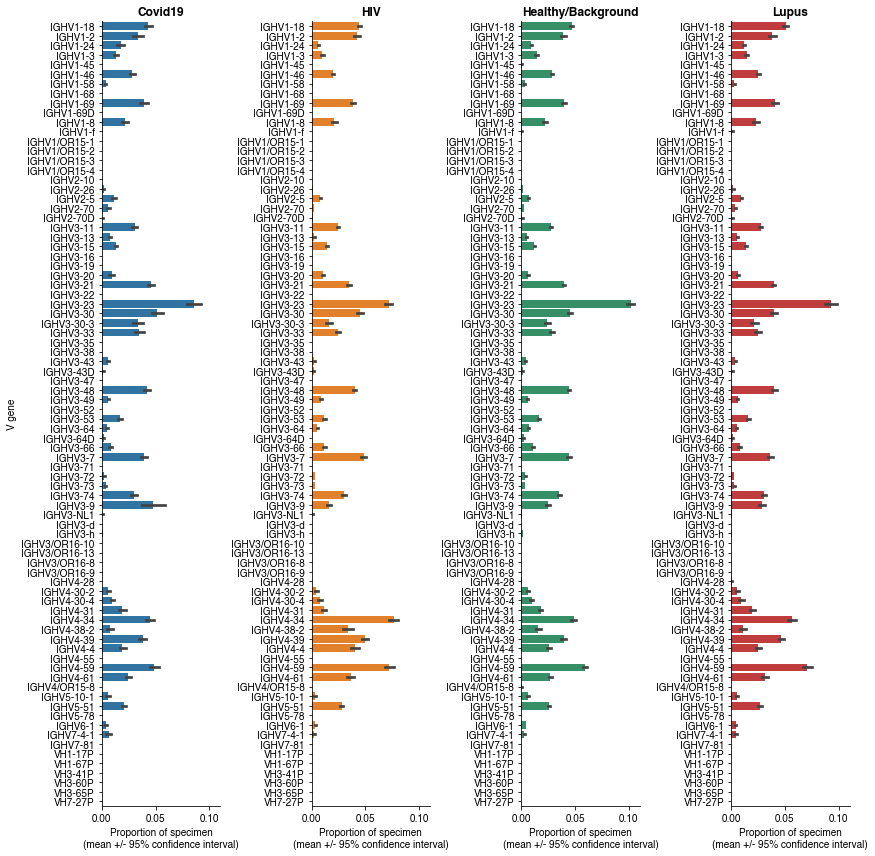

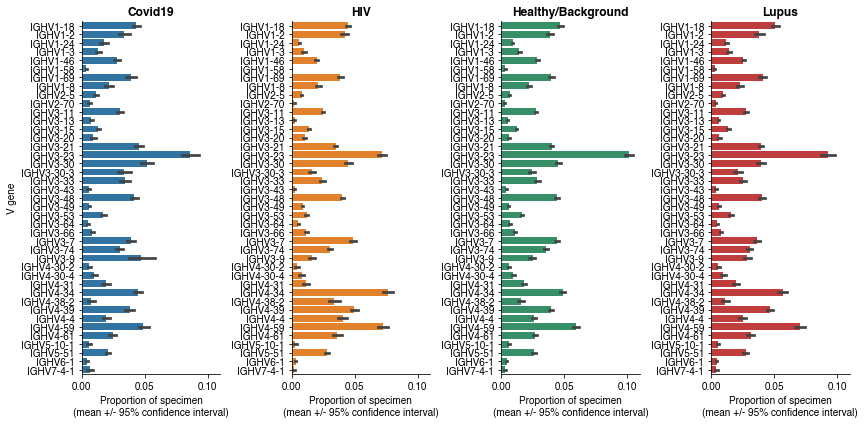

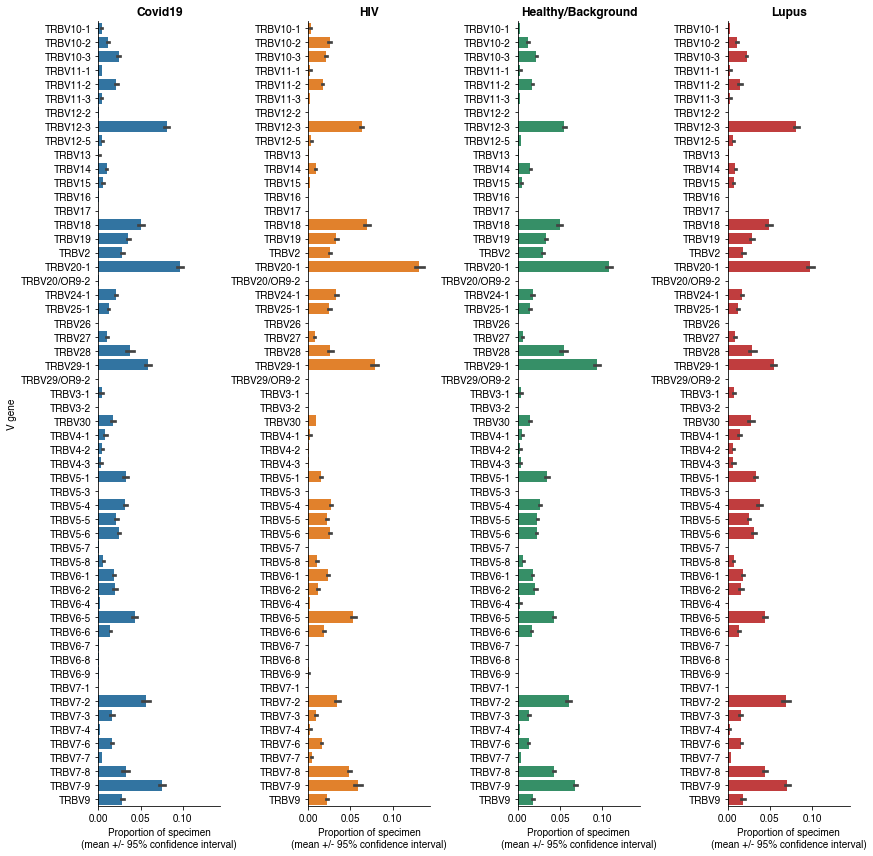

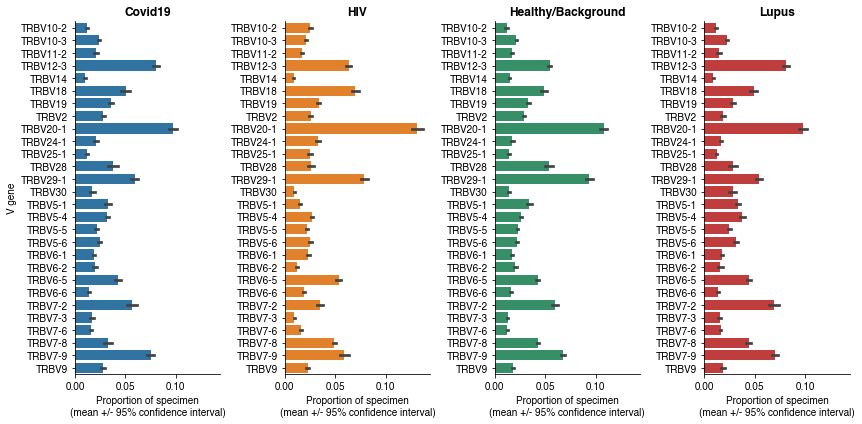

In [8]:
for gene_locus in config.gene_loci_used:
    analyze_v_gene_proportions(gene_locus)

In [9]:
def analyze_cdr3_length_distribution(gene_locus: GeneLocus):
    output_dir, highres_output_dir = get_dirs(gene_locus)

    (
        specimen_cdr3_length_counts_df_test_only,
        cdr3_length_cols,
    ) = import_cdr3_length_counts(gene_locus=gene_locus)

    # Get CDR3 length usage distribution per specimen
    cdr3_length_distribution_by_specimen = pd.concat(
        [
            genetools.stats.normalize_rows(
                specimen_cdr3_length_counts_df_test_only[cdr3_length_cols]
            ),
            specimen_cdr3_length_counts_df_test_only["disease"],
        ],
        axis=1,
    )

    cdr3_length_distribution_by_specimen_melt = pd.melt(
        cdr3_length_distribution_by_specimen,
        id_vars=["disease"],
        value_vars=cdr3_length_cols,
        var_name="CDR3 length",
        value_name="Proportion",
    )

    def plot(cdr3_length_distribution_by_specimen_melt, filtered=False):
        height = 6 if filtered else 12
        diseases = sorted(cdr3_length_distribution_by_specimen_melt["disease"].unique())

        fig, axarr = plt.subplots(
            nrows=1,
            ncols=len(diseases),
            figsize=(3 * len(diseases), height),
            sharex=True,  # Make xlims consistent for better readability
            sharey=False,  # Repeat the V gene in each axis for better readability
        )
        for (disease, ax) in zip(diseases, axarr):
            sns.barplot(
                data=cdr3_length_distribution_by_specimen_melt[
                    cdr3_length_distribution_by_specimen_melt["disease"] == disease
                ],
                x="Proportion",
                y="CDR3 length",
                orient="h",
                order=reversed(sorted(cdr3_length_cols)),
                ax=ax,
                color=helpers.disease_color_palette[disease],
                # Compute 95% confidence intervals around a sample mean by bootstrapping:
                # sampling distribution of mean generated by repeated sampling and recording mean each time.
                # the standard error is basically the standard deviation of many sample means
                # we plot mean +/- 1.96*standard error. gives you average value +/- X at the 95% confidence level.
                ci=95,
                # ci="sd", # instead draw the standard deviation of the observations, instead of bootstrapping to get 95% confidence intervals
                # capsize=.025
            )

            ax.set_title(disease, fontweight="bold")
            ax.set_xlabel("Proportion of specimen\n(mean +/- 95% confidence interval)")
            ax.set_ylabel(None)
            sns.despine(ax=ax)

        axarr[0].set_ylabel(f"CDR3 length ({gene_locus})")
        plt.tight_layout()
        return fig

    ## Plot
    fig = plot(
        cdr3_length_distribution_by_specimen_melt=cdr3_length_distribution_by_specimen_melt,
        filtered=False,
    )


#     genetools.plots.savefig(
#         fig,
#         highres_output_dir / "v_gene_proportions_by_specimen.by_disease.png",
#         dpi=300,
#     )

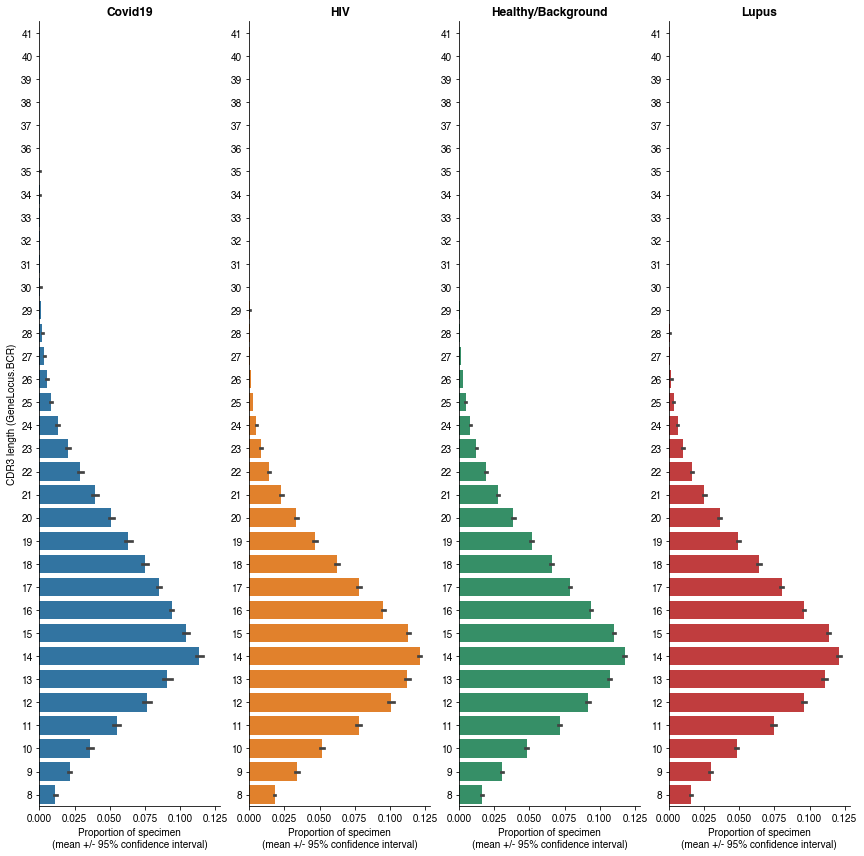

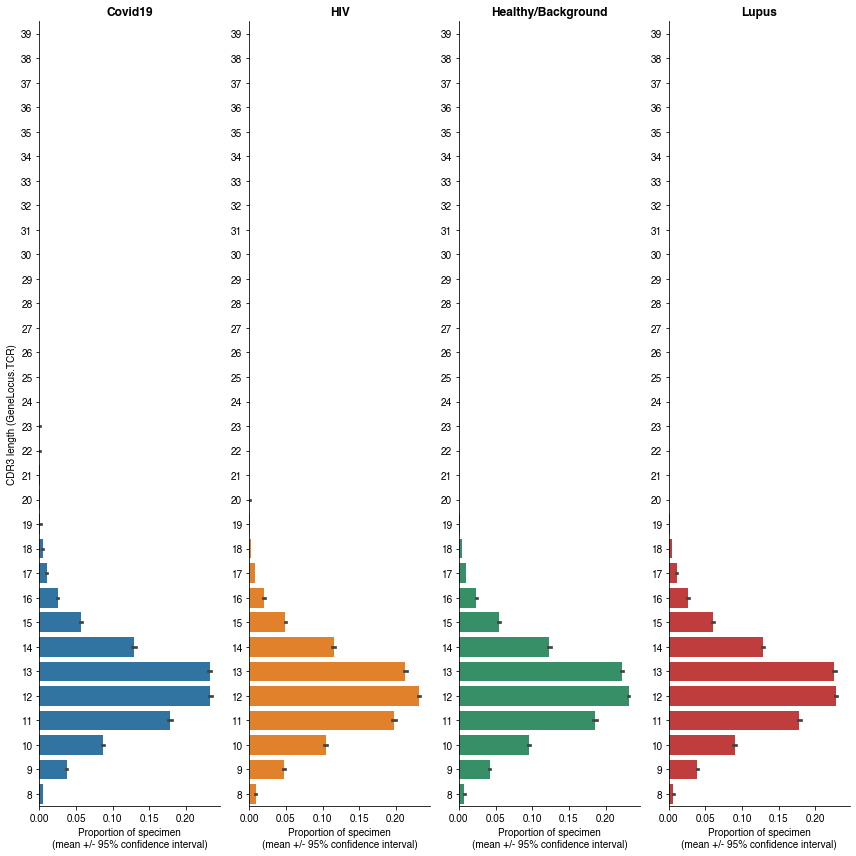

In [10]:
for gene_locus in config.gene_loci_used:
    analyze_cdr3_length_distribution(gene_locus)

## Same but now versus ancestry

Covid19 and Healthy cohorts have many ancestry groups represented

In [11]:
extra_specimen_metadata = helpers.get_all_specimen_info()
extra_specimen_metadata = extra_specimen_metadata[
    extra_specimen_metadata["in_training_set"]
].copy()

extra_specimen_metadata

participant_label specimen_label  disease specimen_time_point  \
0         BFI-0007450      M369-S001  Covid19              9 days   
5         BFI-0007453      M371-S004  Covid19             15 days   
9         BFI-0007455      M371-S031  Covid19             12 days   
13        BFI-0007480      M371-S015  Covid19             14 days   
14        BFI-0007481      M371-S005  Covid19             32 days   
..                ...            ...      ...                 ...   
815       BFI-0010060      M456-S001    Lupus                 NaN   
816       BFI-0010061      M456-S002    Lupus                 NaN   
817       BFI-0010065      M456-S006    Lupus                 NaN   
818       BFI-0010067      M456-S008    Lupus                 NaN   
819       BFI-0010068      M456-S009    Lupus                 NaN   

    participant_description   cohort         study_name  \
0          COVID-19 project  Boydlab  Covid19-buffycoat   
5          COVID-19 project  Boydlab  Covid19-buffycoat   
9          COVID-19 project  Boydlab  Covid19-buffycoat   
13         COVID-19 project  Boydlab  Covid19-buffycoat   
14         COVID-19 project  Boydlab  Covid19-buffycoat   
..                      ...      ...                ...   
815             SLE Patient  Boydlab  New Lupus Paxgene   
816             SLE Patient  Boydlab  New Lupus Paxgene   
817             SLE Patient  Boydlab  New Lupus Paxgene   
818             SLE Patient  Boydlab  New Lupus Paxgene   
819             SLE Patient  Boydlab  New Lupus Paxgene   

                        available_gene_loci                disease_subtype  \
0    (((GeneLocus.BCR)), ((GeneLocus.TCR)))  Covid19 - Sero-positive (ICU)   
5    (((GeneLocus.BCR)), ((GeneLocus.TCR)))  Covid19 - Sero-positive (ICU)   
9    (((GeneLocus.BCR)), ((GeneLocus.TCR)))  Covid19 - Sero-positive (ICU)   
13   (((GeneLocus.BCR)), ((GeneLocus.TCR)))  Covid19 - Sero-positive (ICU)   
14   (((GeneLocus.BCR)), ((GeneLocus.TCR)))  Covid19 - Sero-positive (ICU)   
..                                      ...                            ...   
815  (((GeneLocus.BCR)), ((GeneLocus.TCR)))                    SLE Patient   
816  (((GeneLocus.BCR)), ((GeneLocus.TCR)))                    SLE Patient   
817  (((GeneLocus.BCR)), ((GeneLocus.TCR)))                    SLE Patient   
818  (((GeneLocus.BCR)), ((GeneLocus.TCR)))                    SLE Patient   
819  (((GeneLocus.BCR)), ((GeneLocus.TCR)))                    SLE Patient   

      age  ...  cmv disease_severity specimen_time_point_days  \
0    73.0  ...  NaN              ICU                      9.0   
5    64.0  ...  NaN              ICU                     15.0   
9    36.0  ...  NaN              ICU                     12.0   
13   40.0  ...  NaN              ICU                     14.0   
14   66.0  ...  NaN              ICU                     32.0   
..    ...  ...  ...              ...                      ...   
815  51.0  ...  NaN              NaN                      NaN   
816  34.0  ...  NaN              NaN                      NaN   
817  46.0  ...  NaN              NaN                      NaN   
818  49.0  ...  NaN              NaN                      NaN   
819  42.0  ...  NaN              NaN                      NaN   

    cov2_seropositivity survived_filters is_peak in_training_set  \
0           Not exposed             True    True            True   
5           Not exposed             True    True            True   
9           Not exposed             True    True            True   
13          Not exposed             True    True            True   
14          Not exposed             True    True            True   
..                  ...              ...     ...             ...   
815         Not exposed             True    True            True   
816         Not exposed             True    True            True   
817         Not exposed             True    True            True   
818         Not exposed             True    True            True   


In [12]:
extra_specimen_metadata["disease_subtype"].value_counts()

HIV Non Neutralizing                               53
Healthy/Background - CMV Negative                  53
Healthy/Background - CMV Positive                  48
HIV Broad Neutralizing                             45
Healthy/Background (children)                      43
Healthy/Background - HIV Negative                  43
Covid19 - Admit                                    33
Healthy/Background - SLE Negative                  27
Pediatric SLE - nephritis                          23
SLE Patient                                        21
Pediatric SLE - no nephritis                       20
Covid19 - ICU                                      15
SLE Multiple aAbs / SLE dsDNA WITH Nephritis        9
SLE Multiple aAbs / SLE dsDNA WITHOUT Nephritis     9
SLE Multiple aAbs                                   8
Covid19 - Sero-positive (ICU)                       7
Unaffected Control                                  6
Covid19 - Acute 2                                   5
SLE One aAbs                

In [13]:
extra_specimen_metadata["study_name"].value_counts()

HIV                            141
Healthy-StanfordBloodCenter    102
Lupus                           61
Covid19-Stanford                48
healthy_children                43
Lupus Pediatric                 43
New Lupus RNA                   20
Covid19-buffycoat               10
New Lupus Paxgene                7
Covid19-Seattle                  5
Name: study_name, dtype: int64

In [14]:
extra_specimen_metadata["disease_severity"].value_counts()

Admit    36
ICU      22
Name: disease_severity, dtype: int64

In [15]:
extra_specimen_metadata.groupby(["study_name", "disease_severity"]).size()

study_name         disease_severity
Covid19-Stanford   Admit               33
                   ICU                 15
Covid19-buffycoat  Admit                3
                   ICU                  7
dtype: int64

In [16]:
def analyze_v_gene_proportions_by_subgroup(gene_locus: GeneLocus, group_key: str):
    output_dir, highres_output_dir = get_dirs(gene_locus)

    (
        specimen_v_gene_counts_df_test_only,
        v_gene_cols,
        v_gene_cols_filtered,
    ) = import_v_gene_counts(gene_locus=gene_locus)

    # Get V gene usage proportions per specimen
    v_gene_usage_proportions_by_specimen = pd.concat(
        [
            genetools.stats.normalize_rows(
                specimen_v_gene_counts_df_test_only[v_gene_cols]
            ),
            specimen_v_gene_counts_df_test_only["disease"],
        ],
        axis=1,
    )

    v_gene_usage_proportions_by_specimen_annot = genetools.helpers.merge_into_left(
        v_gene_usage_proportions_by_specimen[v_gene_cols],
        extra_specimen_metadata.set_index("specimen_label"),
    )
    assert (
        v_gene_usage_proportions_by_specimen_annot.shape[0]
        == v_gene_usage_proportions_by_specimen.shape[0]
    )
    assert not v_gene_usage_proportions_by_specimen_annot["disease"].isna().any()

    # drop specimens with group N/A
    v_gene_usage_proportions_by_specimen_annot = (
        v_gene_usage_proportions_by_specimen_annot.dropna(subset=[group_key])
    )

    v_gene_usage_proportions_by_specimen_annot_melt = pd.melt(
        v_gene_usage_proportions_by_specimen_annot,
        id_vars=["disease", group_key],
        value_vars=v_gene_cols,
        var_name="V gene",
        value_name="Proportion",
    )

    group_color_palette = {
        group: color
        for group, color in zip(
            sorted(v_gene_usage_proportions_by_specimen_annot_melt[group_key].unique()),
            sc.plotting.palettes.default_20,
        )
    }

    def plot_per_disease(
        v_gene_usage_proportions_by_specimen_annot_melt: pd.DataFrame,
        disease: str,
        filtered=False,
    ):
        height = 6 if filtered else 12
        selected_v_gene_order = pd.Series(
            v_gene_cols_filtered if filtered else v_gene_cols
        )

        v_gene_usage_proportions_by_specimen_annot_melt_this_disease = (
            v_gene_usage_proportions_by_specimen_annot_melt[
                v_gene_usage_proportions_by_specimen_annot_melt["disease"] == disease
            ]
        )
        # Sort for consistent group order
        groups_this_disease = sorted(
            v_gene_usage_proportions_by_specimen_annot_melt_this_disease[
                group_key
            ].unique()
        )
        if len(groups_this_disease) == 0:
            print(f"No {group_key} group info for {disease} - skipping")
            return None

        # Divide the disease plot into subplots by group
        fig, axarr = plt.subplots(
            nrows=1,
            ncols=len(groups_this_disease),
            figsize=(3 * len(groups_this_disease), height),
            sharex=True,  # Make xlims consistent for better readability
            sharey=False,  # Repeat the V gene in each axis for better readability
        )
        for (group, ax) in zip(groups_this_disease, axarr):
            data = v_gene_usage_proportions_by_specimen_annot_melt_this_disease[
                v_gene_usage_proportions_by_specimen_annot_melt_this_disease[group_key]
                == group
            ]
            sns.barplot(
                # Switch to friendly V gene names
                data=data.assign(
                    **{"V gene": data["V gene"].replace(helpers.v_gene_friendly_names)}
                ),
                x="Proportion",
                y="V gene",
                # reference V gene order, possibly filtered down
                order=sorted(
                    selected_v_gene_order.replace(helpers.v_gene_friendly_names)
                ),
                ax=ax,
                color=group_color_palette[group],
                # Compute 95% confidence intervals around a sample mean by bootstrapping:
                # sampling distribution of mean generated by repeated sampling and recording mean each time.
                # the standard error is basically the standard deviation of many sample means
                # we plot mean +/- 1.96*standard error. gives you average value +/- X at the 95% confidence level.
                ci=95,
                # ci="sd", # instead draw the standard deviation of the observations, instead of bootstrapping to get 95% confidence intervals
                # capsize=.025
            )

            # compute sample size per disease and group, using dataframe from before melting but after N/As were dropped
            sample_size = v_gene_usage_proportions_by_specimen_annot[
                (v_gene_usage_proportions_by_specimen_annot["disease"] == disease)
                & (v_gene_usage_proportions_by_specimen_annot[group_key] == group)
            ].shape[0]

            ax.set_title(f"{group} $(n={sample_size})$", fontweight="bold")
            ax.set_xlabel("Proportion of specimen\n(mean +/- 95% confidence interval)")
            ax.set_ylabel(None)
            sns.despine(ax=ax)

        axarr[0].set_ylabel("V gene")
        fig.suptitle(f"{disease} ({gene_locus})", fontsize="x-large", fontweight="bold")
        plt.tight_layout()
        return fig

    # Make a plot for each disease
    for disease in ["Covid19", "Lupus", healthy_label]:
        # Plot for all V genes
        fig = plot_per_disease(
            v_gene_usage_proportions_by_specimen_annot_melt=v_gene_usage_proportions_by_specimen_annot_melt,
            disease=disease,
            filtered=False,
        )
        if fig is not None:
            genetools.plots.savefig(
                fig,
                highres_output_dir
                / f"v_gene_proportions_by_specimen.disease.{slugify(disease)}.by_{group_key}.png",
                dpi=300,
            )

        # Repeat, for subset of V genes
        fig = plot_per_disease(
            v_gene_usage_proportions_by_specimen_annot_melt=v_gene_usage_proportions_by_specimen_annot_melt,
            disease=disease,
            filtered=True,
        )
        if fig is not None:
            genetools.plots.savefig(
                fig,
                output_dir
                / f"v_gene_proportions_by_specimen.filtered_v_genes.disease.{slugify(disease)}.by_{group_key}.png",
                dpi=300,
            )

    return v_gene_usage_proportions_by_specimen_annot_melt

In [17]:
def analyze_cdr3_length_distribution_by_subgroup(gene_locus: GeneLocus, group_key: str):
    output_dir, highres_output_dir = get_dirs(gene_locus)

    (
        specimen_cdr3_length_counts_df_test_only,
        cdr3_length_cols,
    ) = import_cdr3_length_counts(gene_locus=gene_locus)

    # Get CDR3 length usage distribution per specimen
    cdr3_length_distribution_by_specimen = pd.concat(
        [
            genetools.stats.normalize_rows(
                specimen_cdr3_length_counts_df_test_only[cdr3_length_cols]
            ),
            specimen_cdr3_length_counts_df_test_only["disease"],
        ],
        axis=1,
    )

    cdr3_length_distribution_by_specimen_annot = genetools.helpers.merge_into_left(
        cdr3_length_distribution_by_specimen[cdr3_length_cols],
        extra_specimen_metadata.set_index("specimen_label"),
    )
    assert (
        cdr3_length_distribution_by_specimen_annot.shape[0]
        == cdr3_length_distribution_by_specimen.shape[0]
    )
    assert not cdr3_length_distribution_by_specimen_annot["disease"].isna().any()

    # drop specimens with group N/A
    cdr3_length_distribution_by_specimen_annot = (
        cdr3_length_distribution_by_specimen_annot.dropna(subset=[group_key])
    )

    cdr3_length_distribution_by_specimen_annot_melt = pd.melt(
        cdr3_length_distribution_by_specimen_annot,
        id_vars=["disease", group_key],
        value_vars=cdr3_length_cols,
        var_name="CDR3 length",
        value_name="Proportion",
    )

    group_color_palette = {
        group: color
        for group, color in zip(
            sorted(cdr3_length_distribution_by_specimen_annot_melt[group_key].unique()),
            sc.plotting.palettes.default_20,
        )
    }

    def plot_per_disease(
        cdr3_length_distribution_by_specimen_annot_melt: pd.DataFrame,
        disease: str,
        filtered=False,
    ):
        height = 6 if filtered else 12
        cdr3_length_distribution_by_specimen_annot_melt_this_disease = (
            cdr3_length_distribution_by_specimen_annot_melt[
                cdr3_length_distribution_by_specimen_annot_melt["disease"] == disease
            ]
        )
        # Sort for consistent group order
        groups_this_disease = sorted(
            cdr3_length_distribution_by_specimen_annot_melt_this_disease[
                group_key
            ].unique()
        )
        if len(groups_this_disease) == 0:
            print(f"No {group_key} group info for {disease} - skipping")
            return None

        # Divide the disease plot into subplots by group
        fig, axarr = plt.subplots(
            nrows=1,
            ncols=len(groups_this_disease),
            figsize=(3 * len(groups_this_disease), height),
            sharex=True,  # Make xlims consistent for better readability
            sharey=False,  # Repeat the V gene in each axis for better readability
        )
        for (group, ax) in zip(groups_this_disease, axarr):
            sns.barplot(
                data=cdr3_length_distribution_by_specimen_annot_melt_this_disease[
                    cdr3_length_distribution_by_specimen_annot_melt_this_disease[
                        group_key
                    ]
                    == group
                ],
                x="Proportion",
                y="CDR3 length",
                orient="h",
                order=reversed(sorted(cdr3_length_cols)),
                ax=ax,
                color=group_color_palette[group],
                # Compute 95% confidence intervals around a sample mean by bootstrapping:
                # sampling distribution of mean generated by repeated sampling and recording mean each time.
                # the standard error is basically the standard deviation of many sample means
                # we plot mean +/- 1.96*standard error. gives you average value +/- X at the 95% confidence level.
                ci=95,
                # ci="sd", # instead draw the standard deviation of the observations, instead of bootstrapping to get 95% confidence intervals
                # capsize=.025
            )

            # compute sample size per disease and group, using dataframe from before melting but after N/As were dropped
            sample_size = cdr3_length_distribution_by_specimen_annot[
                (cdr3_length_distribution_by_specimen_annot["disease"] == disease)
                & (cdr3_length_distribution_by_specimen_annot[group_key] == group)
            ].shape[0]

            ax.set_title(f"{group} $(n={sample_size})$", fontweight="bold")
            ax.set_xlabel("Proportion of specimen\n(mean +/- 95% confidence interval)")
            ax.set_ylabel(None)
            sns.despine(ax=ax)

        axarr[0].set_ylabel("CDR3 length")
        fig.suptitle(f"{disease} ({gene_locus})", fontsize="x-large", fontweight="bold")
        plt.tight_layout()
        return fig

    # Make a plot for each disease
    for disease in ["Covid19", "Lupus", healthy_label]:
        # Plot for all V genes
        fig = plot_per_disease(
            cdr3_length_distribution_by_specimen_annot_melt=cdr3_length_distribution_by_specimen_annot_melt,
            disease=disease,
            filtered=False,
        )
    #         if fig is not None:
    #             genetools.plots.savefig(
    #                 fig,
    #                 highres_output_dir
    #                 / f"v_gene_proportions_by_specimen.disease.{slugify(disease)}.by_{group_key}.png",
    #                 dpi=300,
    #             )

    return cdr3_length_distribution_by_specimen_annot_melt

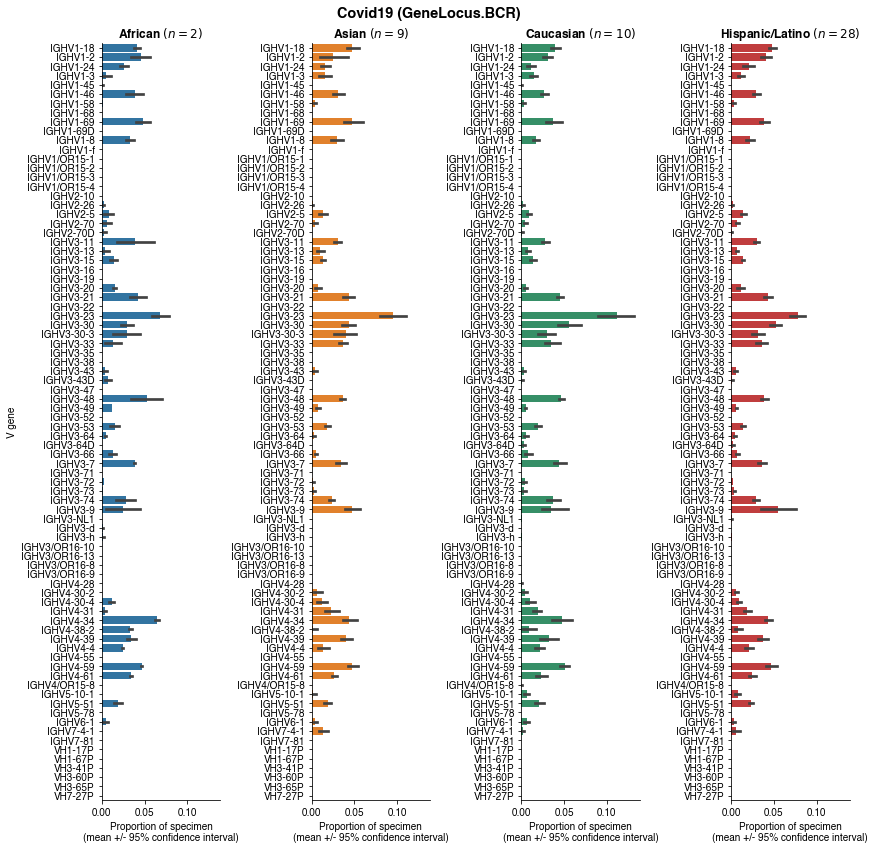

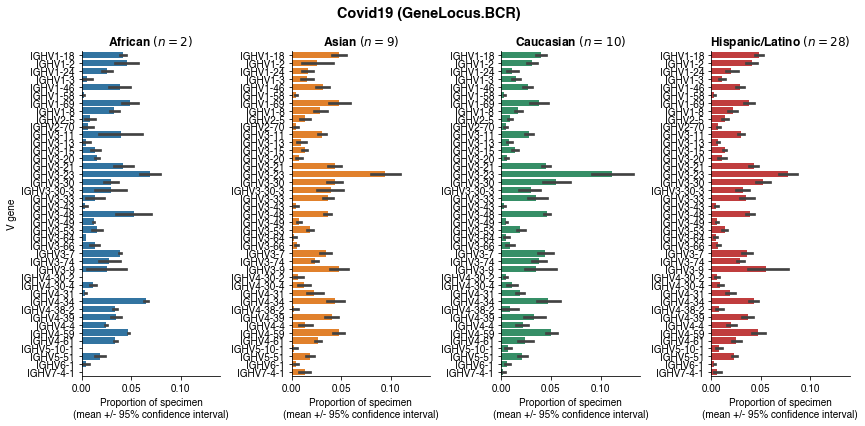

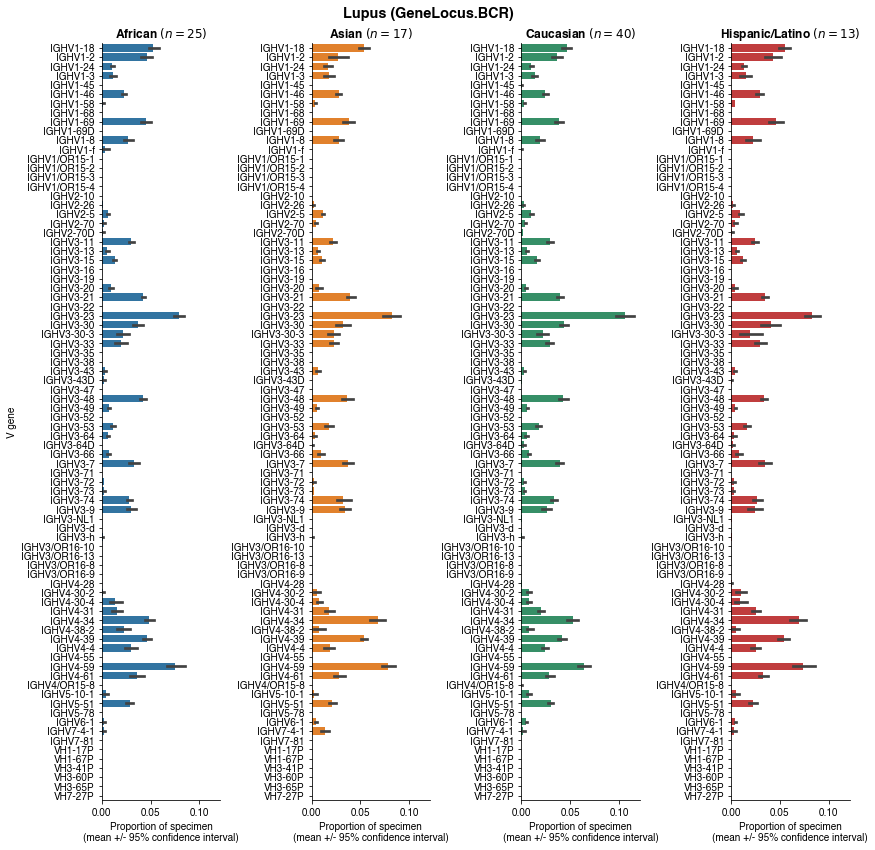

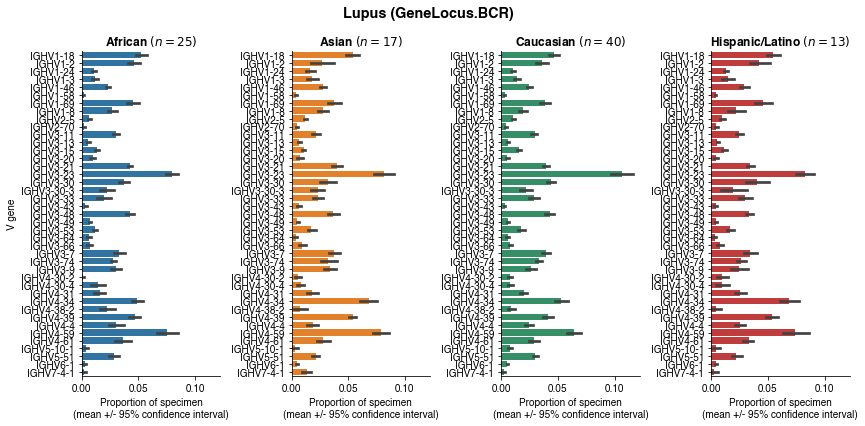

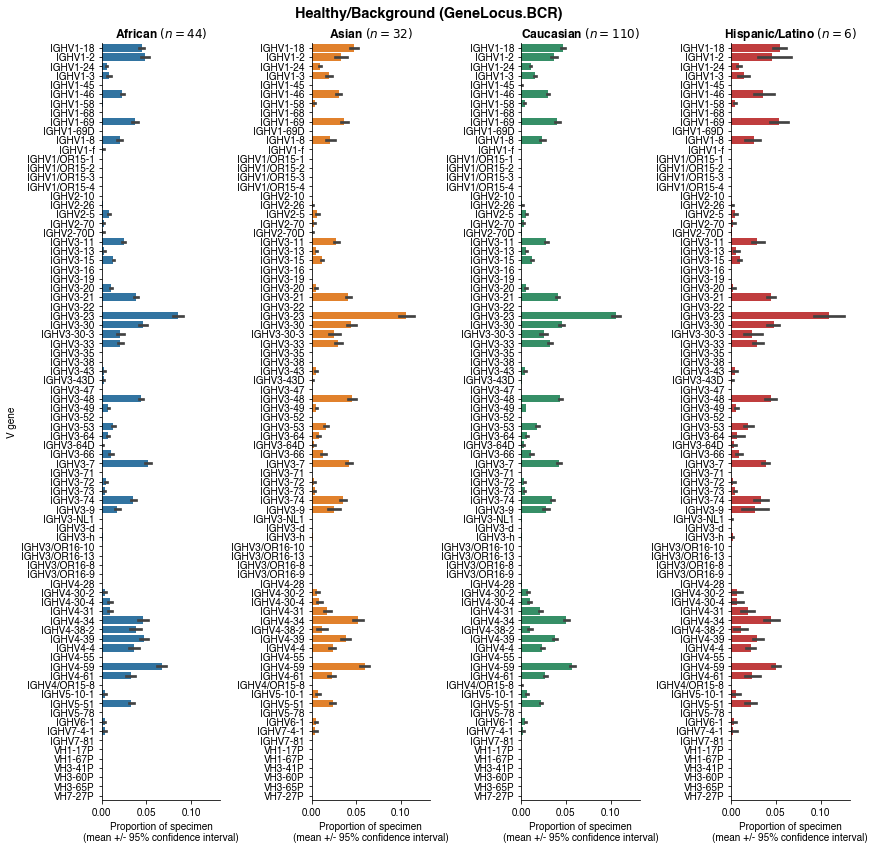

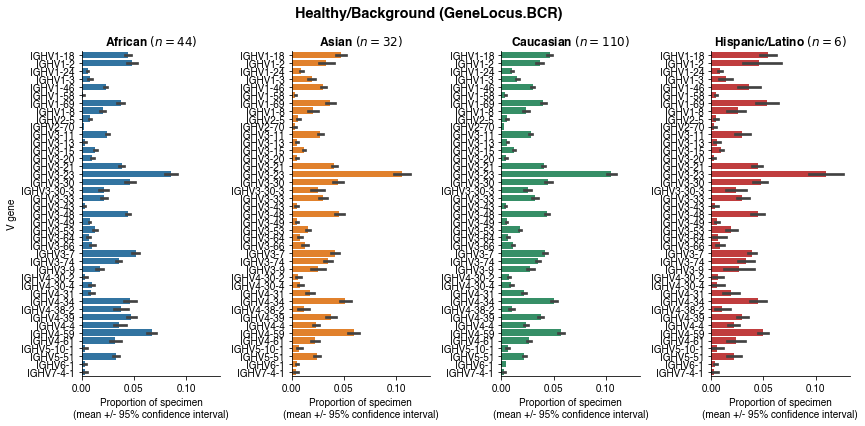

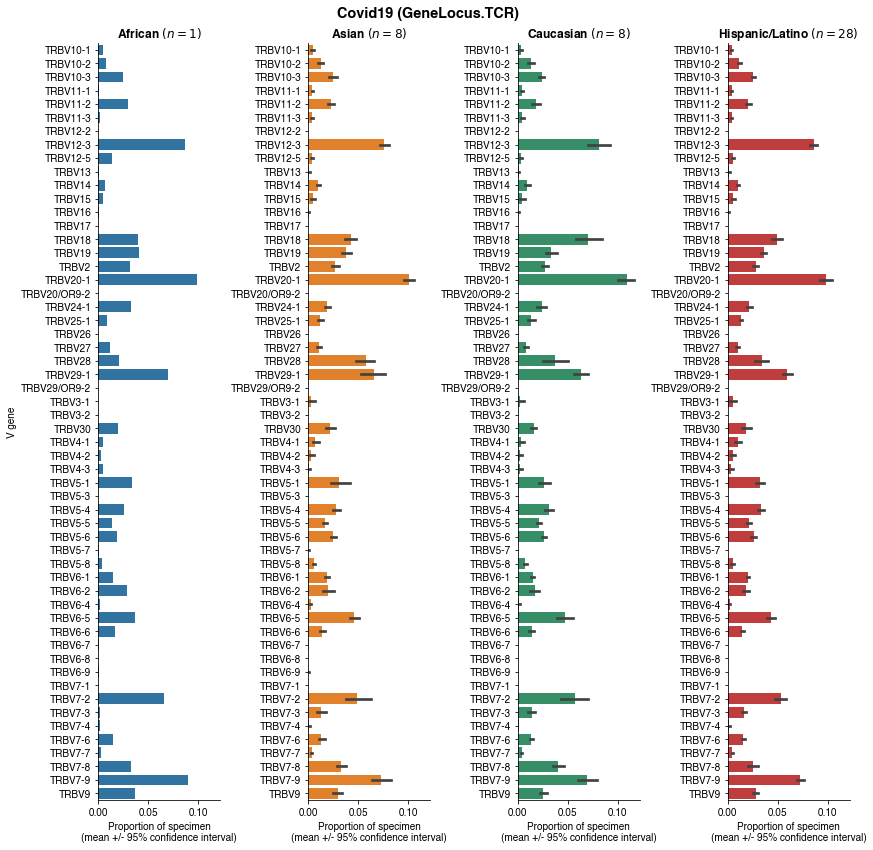

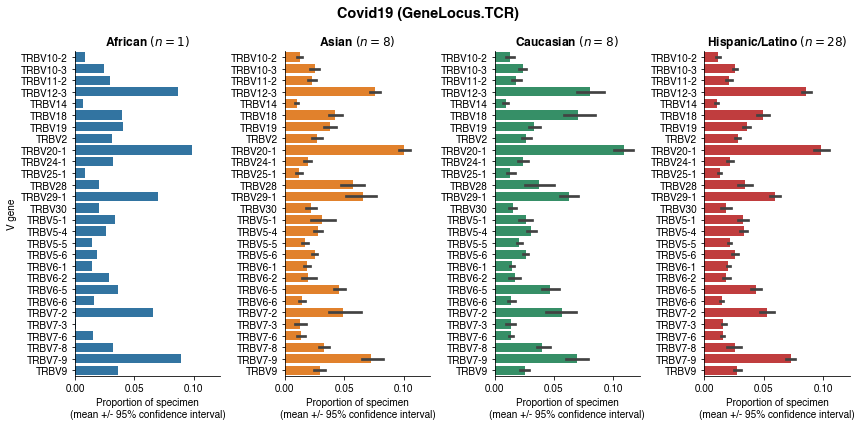

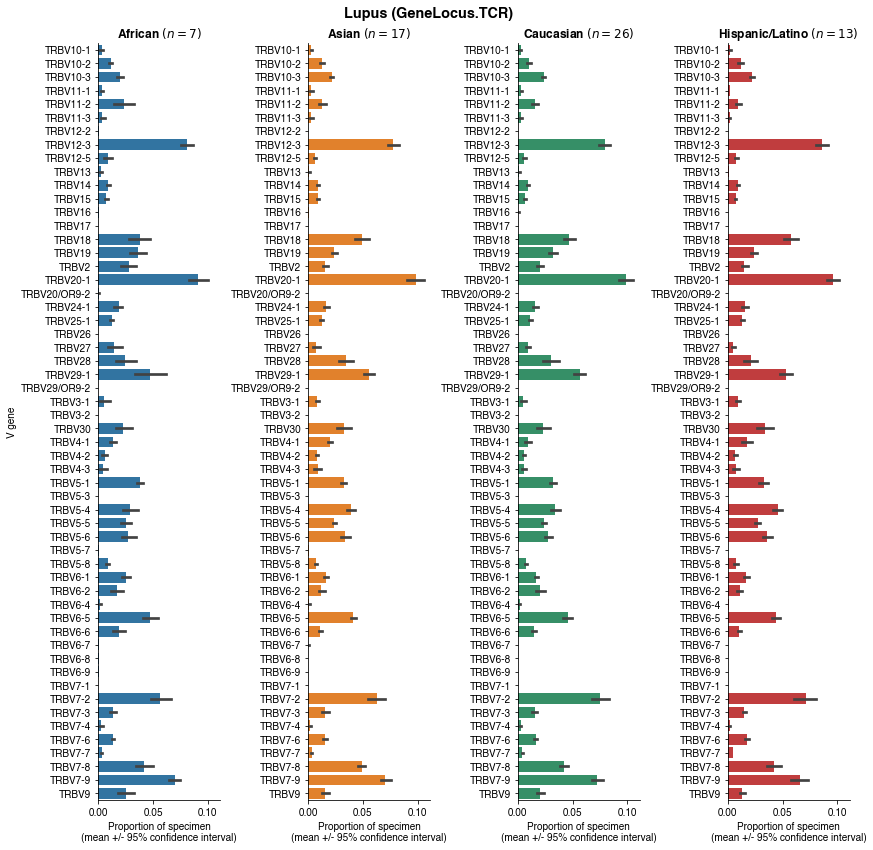

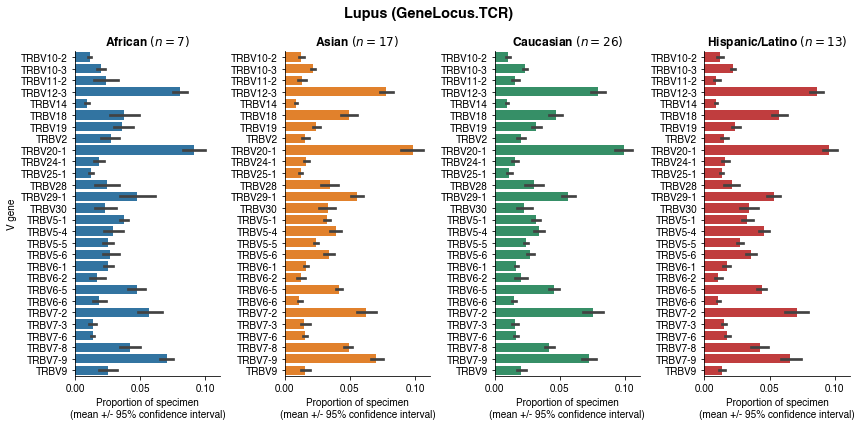

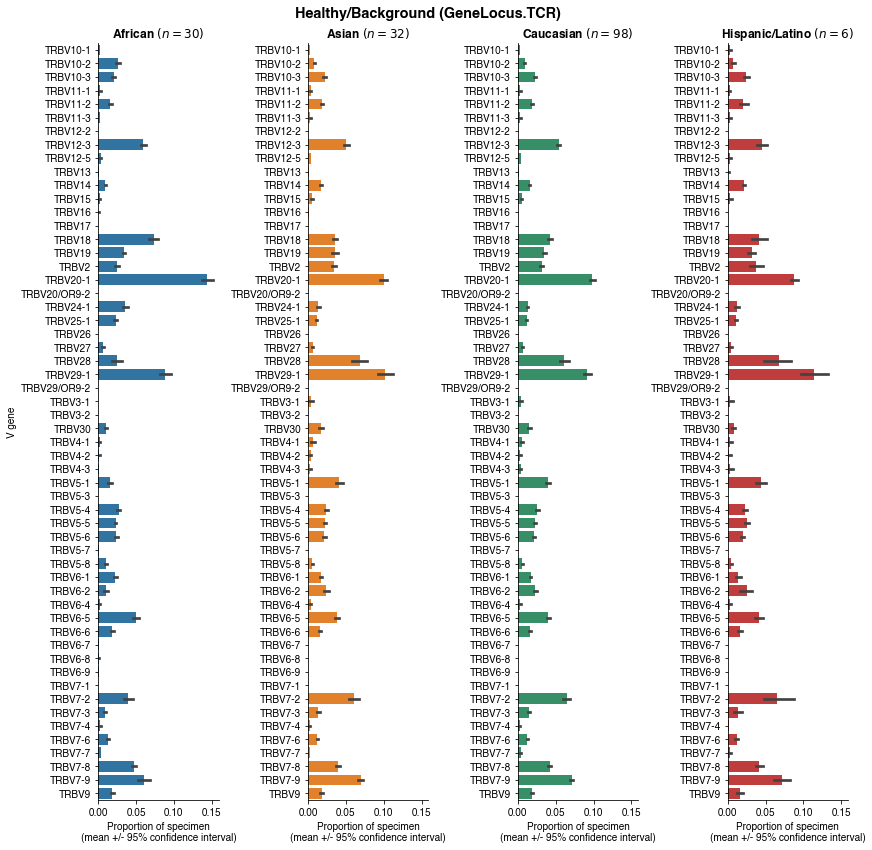

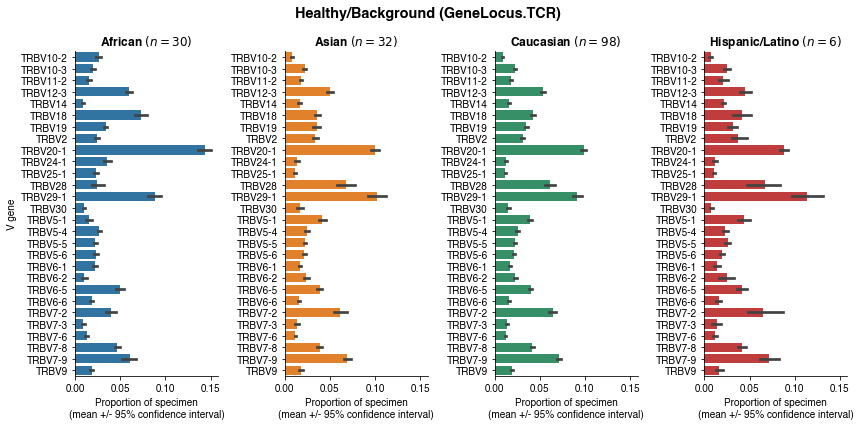

In [18]:
v_gene_use_proportions_by_specimen_and_ethnicity = {}
for gene_locus in config.gene_loci_used:
    v_gene_use_proportions_by_specimen_and_ethnicity[
        gene_locus
    ] = analyze_v_gene_proportions_by_subgroup(
        gene_locus, group_key="ethnicity_condensed"
    )

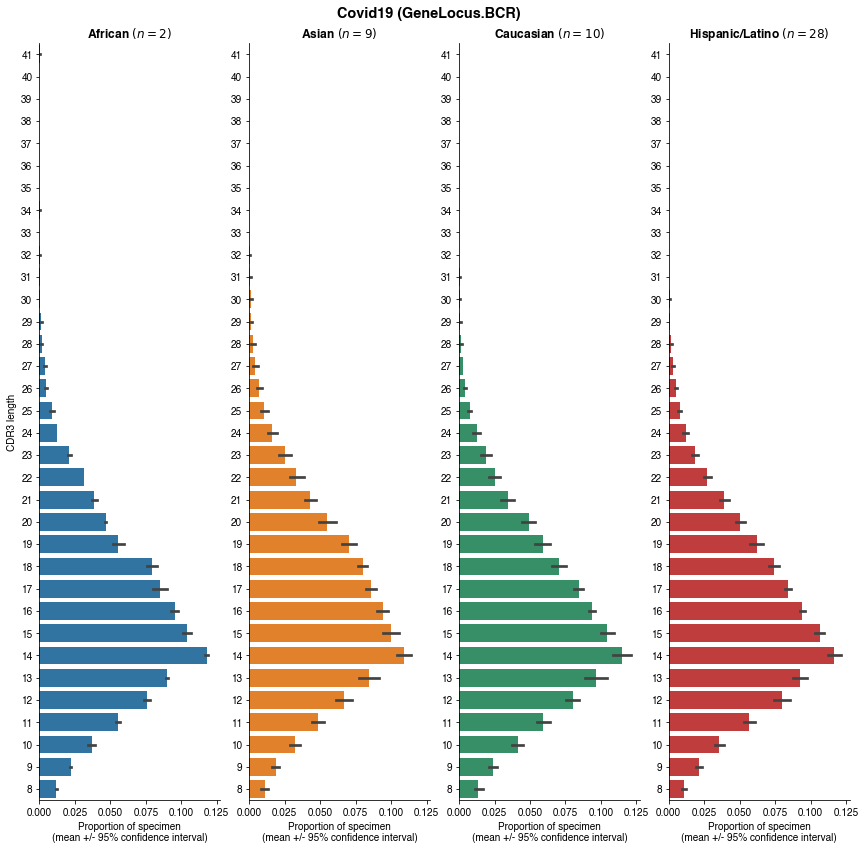

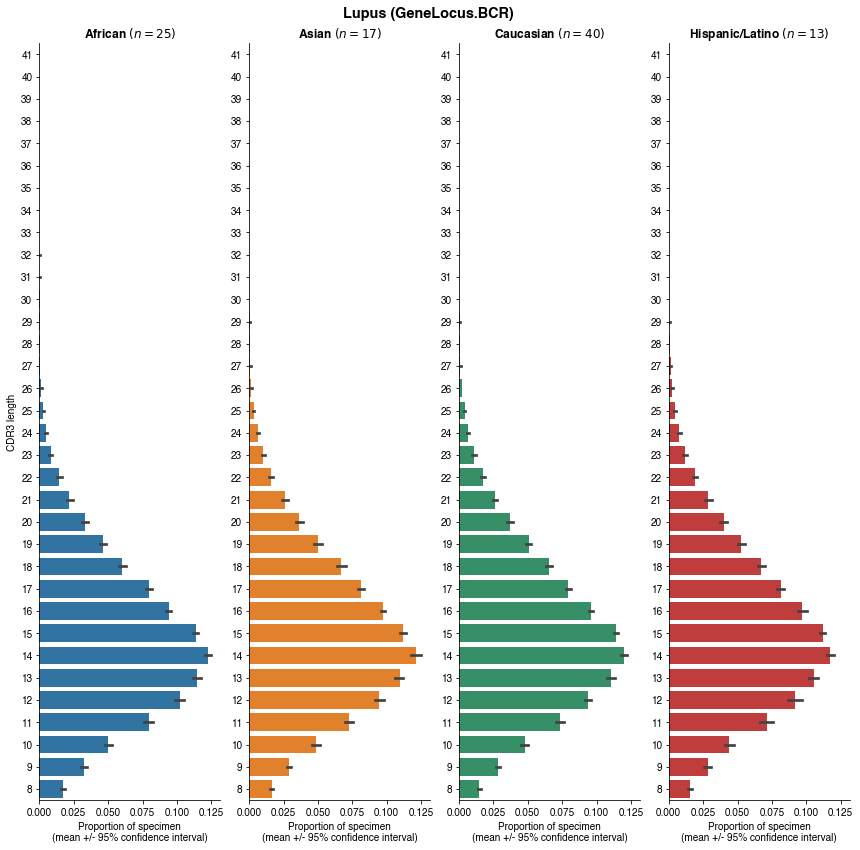

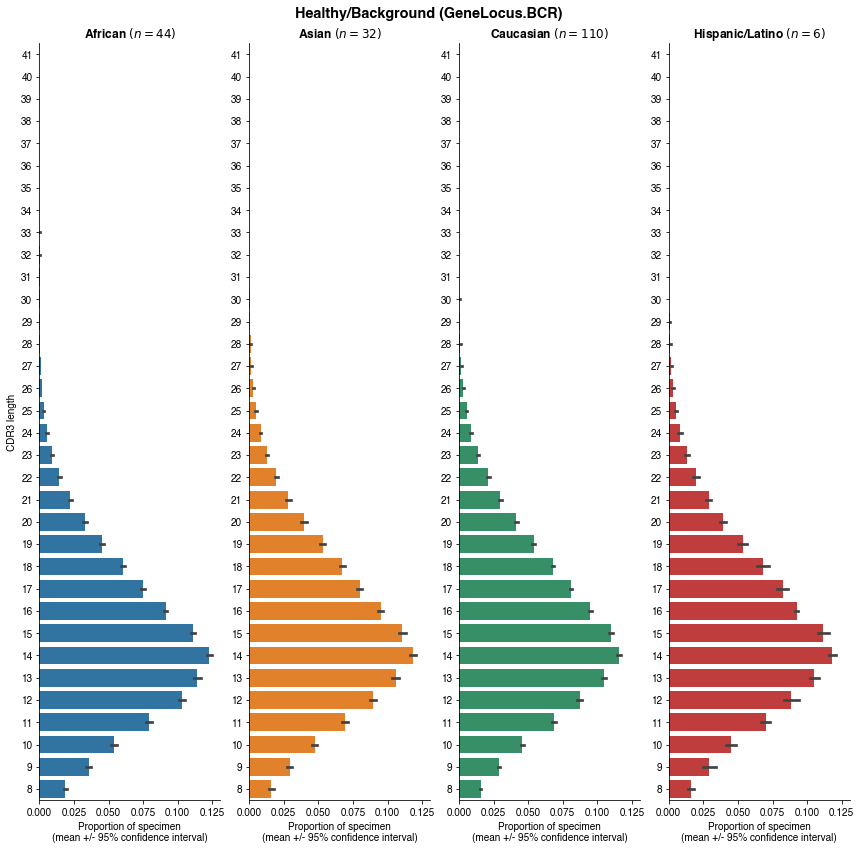

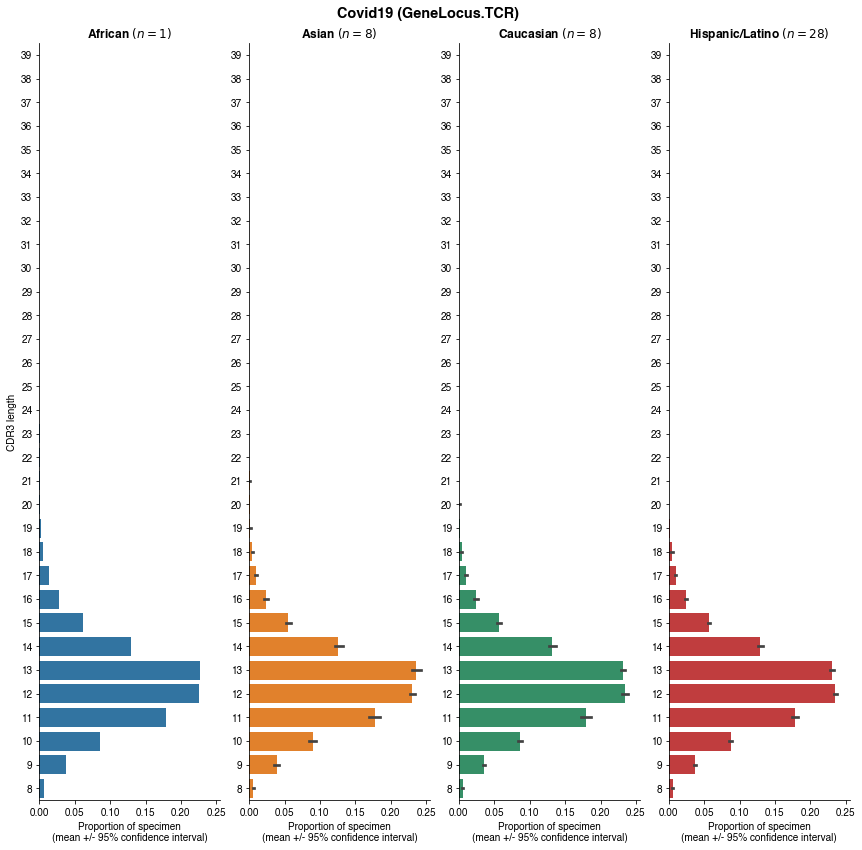

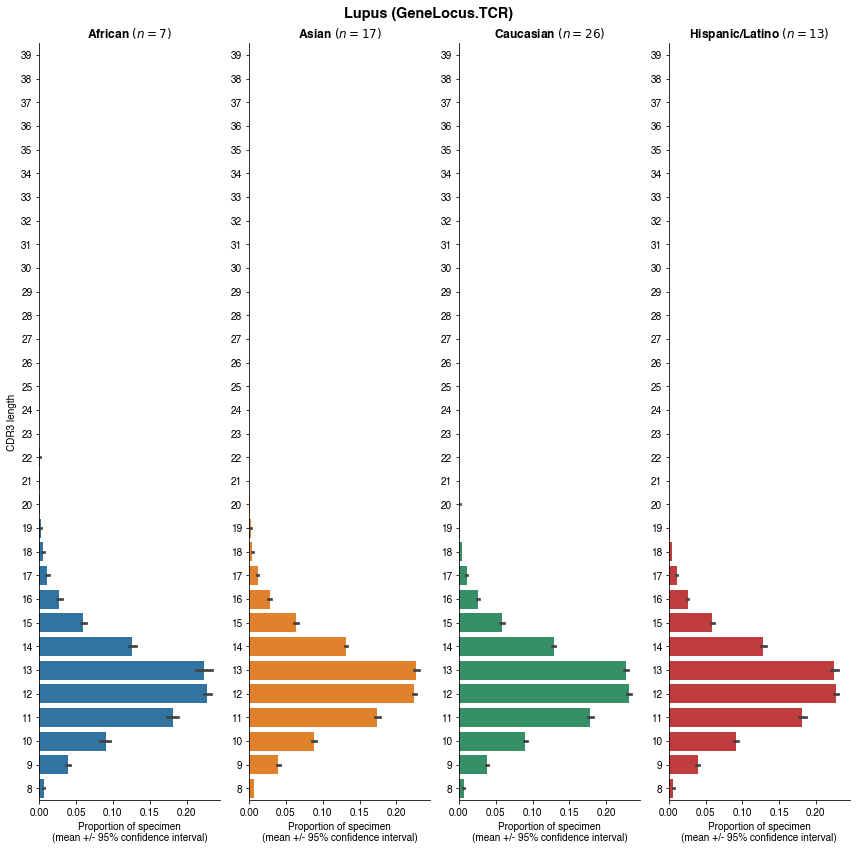

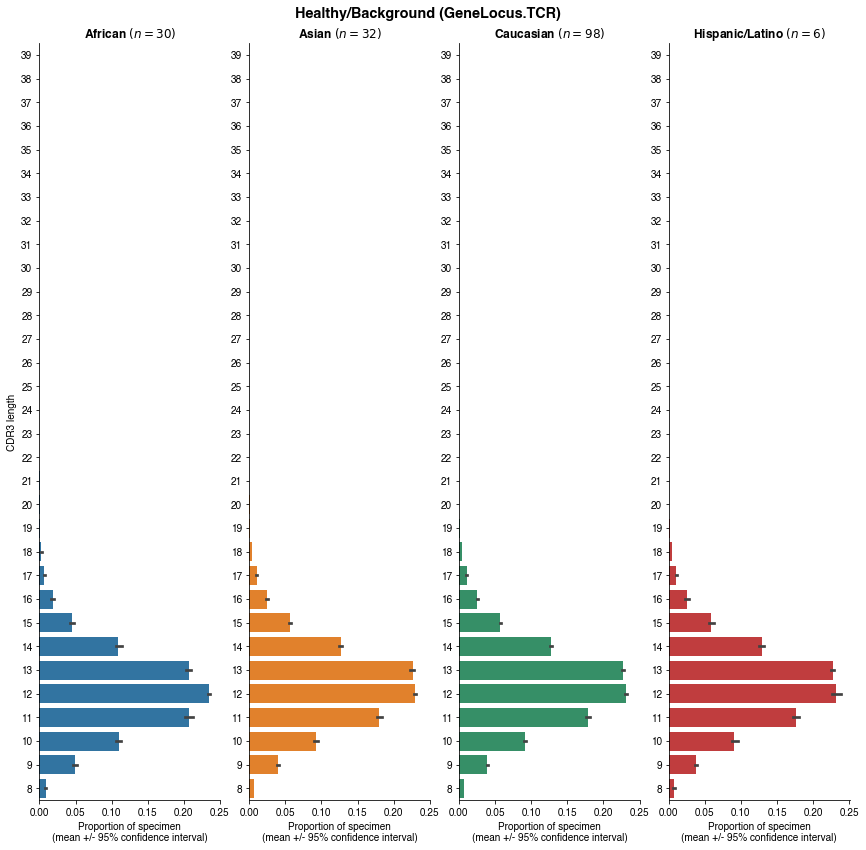

In [19]:
for gene_locus in config.gene_loci_used:
    analyze_cdr3_length_distribution_by_subgroup(
        gene_locus, group_key="ethnicity_condensed"
    )

## Investigate means directly for two V genes of interest

In [20]:
v_gene_usage_proportions_by_specimen_annot_melt = (
    v_gene_use_proportions_by_specimen_and_ethnicity[GeneLocus.BCR]
)
v_gene_usage_proportions_by_specimen_annot_melt

disease ethnicity_condensed   V gene  Proportion
0                     HIV             African  IGHV4-b    0.036676
1                     HIV             African  IGHV4-b    0.017977
2                     HIV             African  IGHV4-b    0.056795
3                     HIV             African  IGHV4-b    0.000060
4                     HIV             African  IGHV4-b    0.029282
...                   ...                 ...      ...         ...
34681  Healthy/Background     Hispanic/Latino  VH3-60P    0.000000
34682  Healthy/Background               Asian  VH3-60P    0.000000
34683  Healthy/Background           Caucasian  VH3-60P    0.000000
34684  Healthy/Background           Caucasian  VH3-60P    0.000000
34685  Healthy/Background           Caucasian  VH3-60P    0.000000

[34686 rows x 4 columns]

In [21]:
v_gene_usage_proportions_by_specimen_annot_melt[
    (
        v_gene_usage_proportions_by_specimen_annot_melt["V gene"].isin(
            ["IGHV5-a", "IGHV4-b"]
        )
    )
    & (
        v_gene_usage_proportions_by_specimen_annot_melt["disease"].isin(
            [healthy_label, "Covid19"]
        )
    )
].groupby(["disease", "V gene", "ethnicity_condensed"])["Proportion"].mean().apply(
    # print as percentage
    lambda mean: f"{mean:0.2%}"
)

disease             V gene   ethnicity_condensed
Covid19             IGHV4-b  African                3.36%
                             Asian                  0.22%
                             Caucasian              0.89%
                             Hispanic/Latino        0.79%
                    IGHV5-a  African                0.00%
                             Asian                  0.23%
                             Caucasian              0.66%
                             Hispanic/Latino        0.76%
Healthy/Background  IGHV4-b  African                3.79%
                             Asian                  1.15%
                             Caucasian              0.98%
                             Hispanic/Latino        1.05%
                    IGHV5-a  African                0.34%
                             Asian                  0.74%
                             Caucasian              0.60%
                             Hispanic/Latino        0.55%
Name: Proportion, dtype

In [22]:
# repeat, without disease filter
v_gene_usage_proportions_by_specimen_annot_melt[
    v_gene_usage_proportions_by_specimen_annot_melt["V gene"].isin(
        ["IGHV5-a", "IGHV4-b"]
    )
].groupby(["disease", "V gene", "ethnicity_condensed"])["Proportion"].mean().apply(
    # print as percentage
    lambda mean: f"{mean:0.2%}"
)

disease             V gene   ethnicity_condensed
Covid19             IGHV4-b  African                3.36%
                             Asian                  0.22%
                             Caucasian              0.89%
                             Hispanic/Latino        0.79%
                    IGHV5-a  African                0.00%
                             Asian                  0.23%
                             Caucasian              0.66%
                             Hispanic/Latino        0.76%
HIV                 IGHV4-b  African                3.68%
                    IGHV5-a  African                0.28%
Healthy/Background  IGHV4-b  African                3.79%
                             Asian                  1.15%
                             Caucasian              0.98%
                             Hispanic/Latino        1.05%
                    IGHV5-a  African                0.34%
                             Asian                  0.74%
                       

In [23]:
# repeat, without disease filter
v_gene_usage_proportions_by_specimen_annot_melt[
    v_gene_usage_proportions_by_specimen_annot_melt["V gene"].isin(
        ["IGHV5-a", "IGHV4-b"]
    )
].groupby(["V gene", "ethnicity_condensed"])["Proportion"].mean().apply(
    # print as percentage
    lambda mean: f"{mean:0.2%}"
)

V gene   ethnicity_condensed
IGHV4-b  African                3.48%
         Asian                  0.89%
         Caucasian              0.94%
         Hispanic/Latino        0.74%
IGHV5-a  African                0.31%
         Asian                  0.53%
         Caucasian              0.64%
         Hispanic/Latino        0.65%
Name: Proportion, dtype: object

# Look at V gene usage and CDR3 length distribution by `study_name`

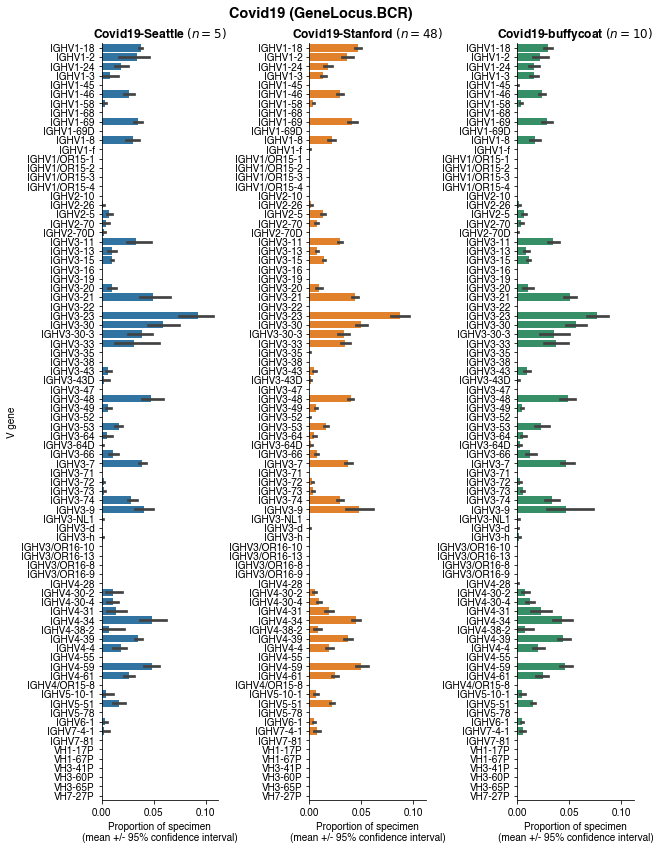

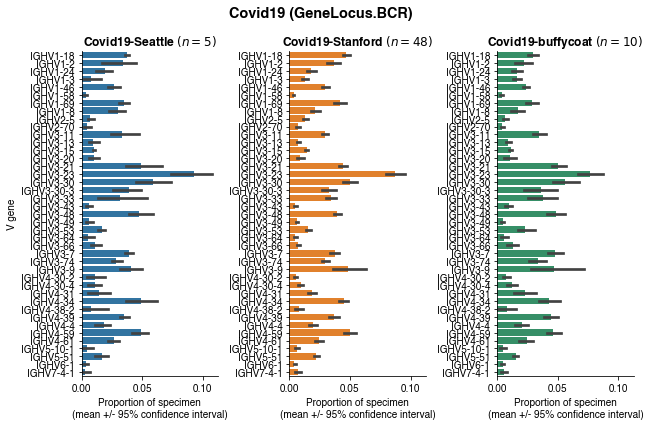

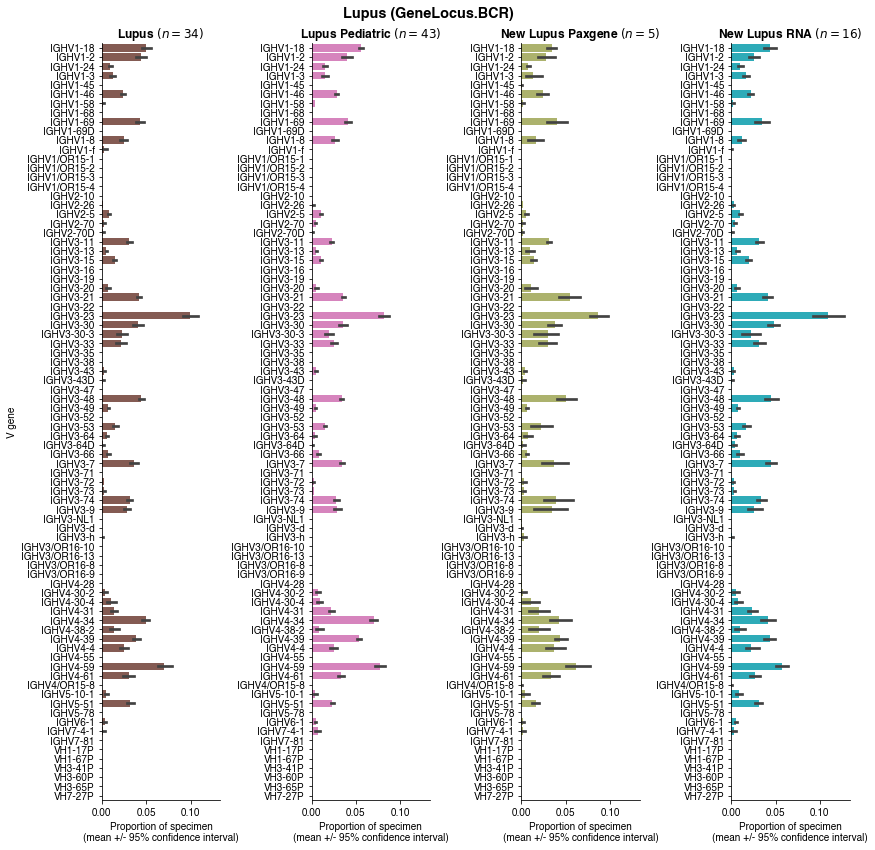

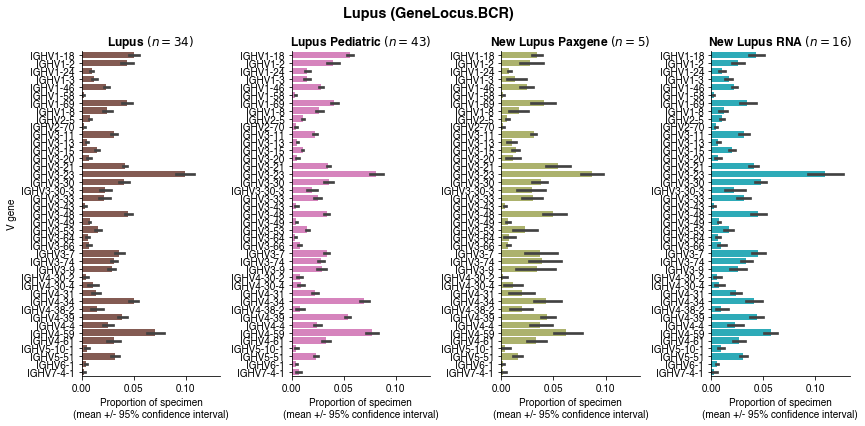

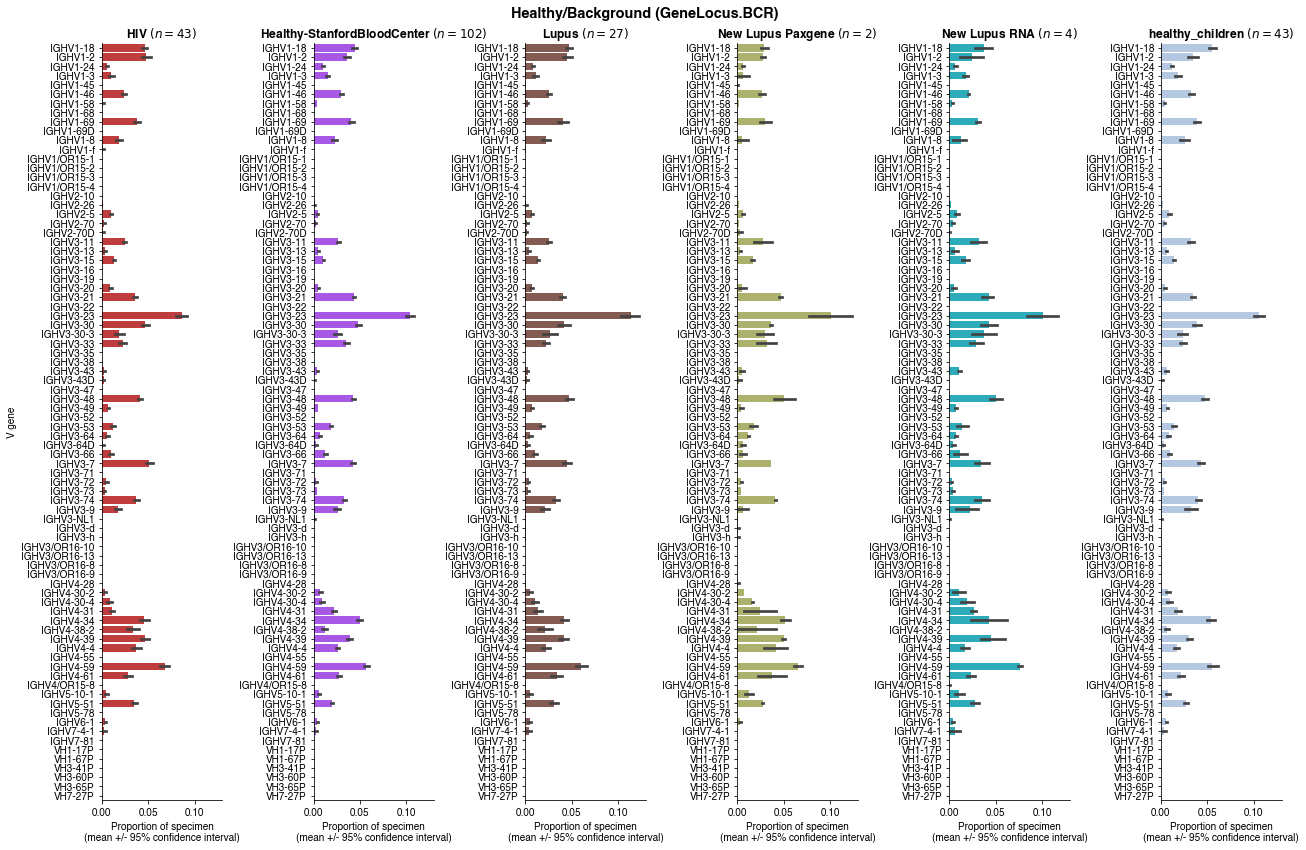

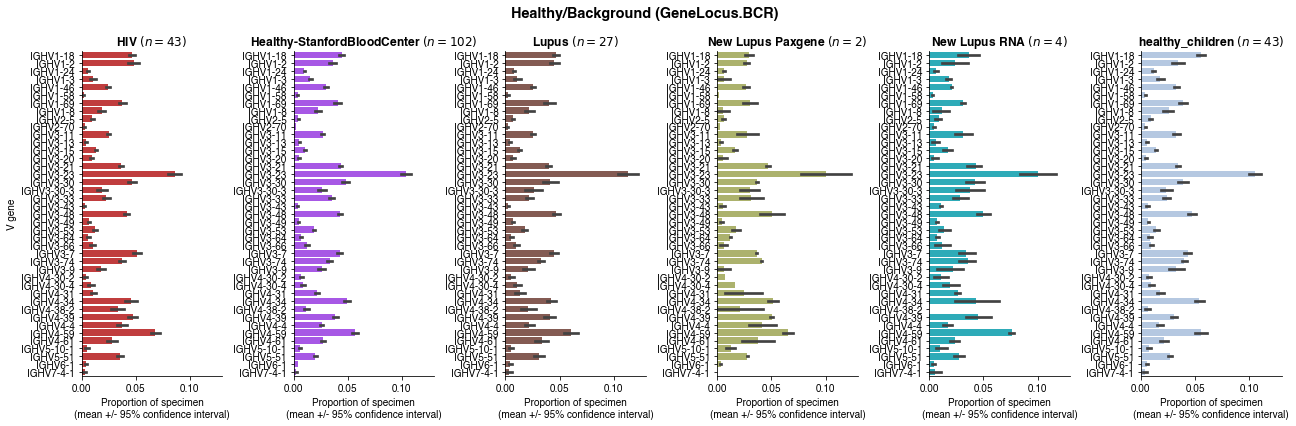

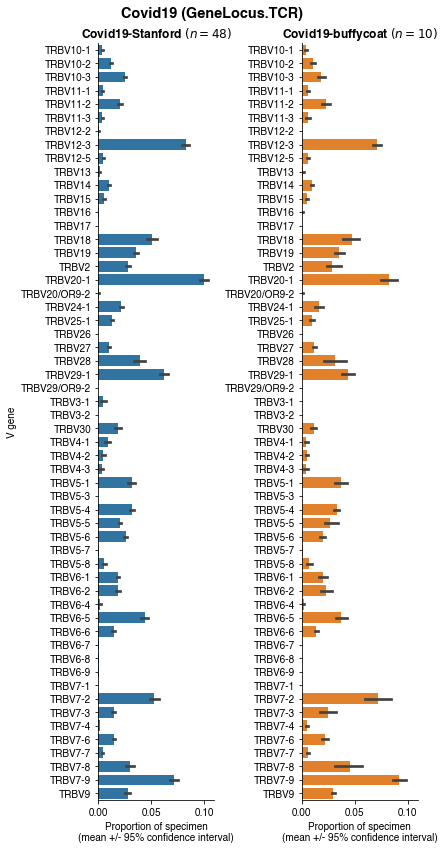

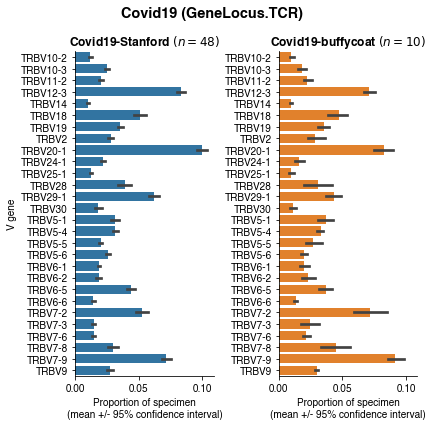

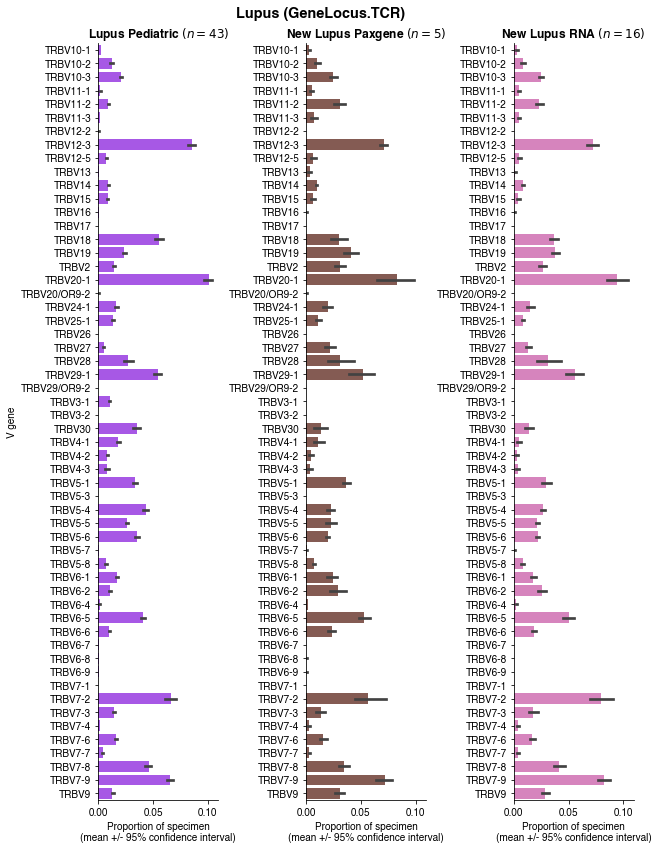

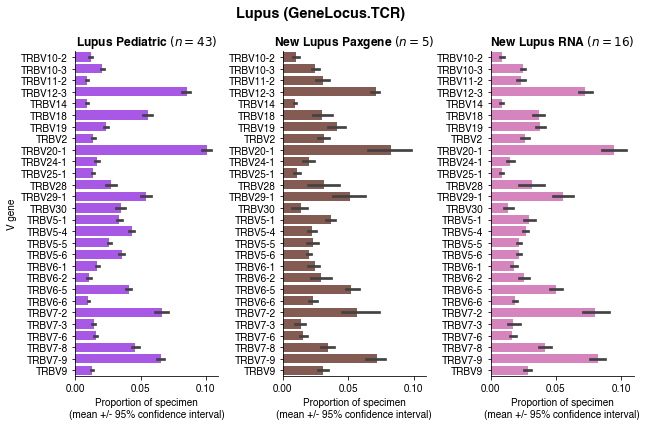

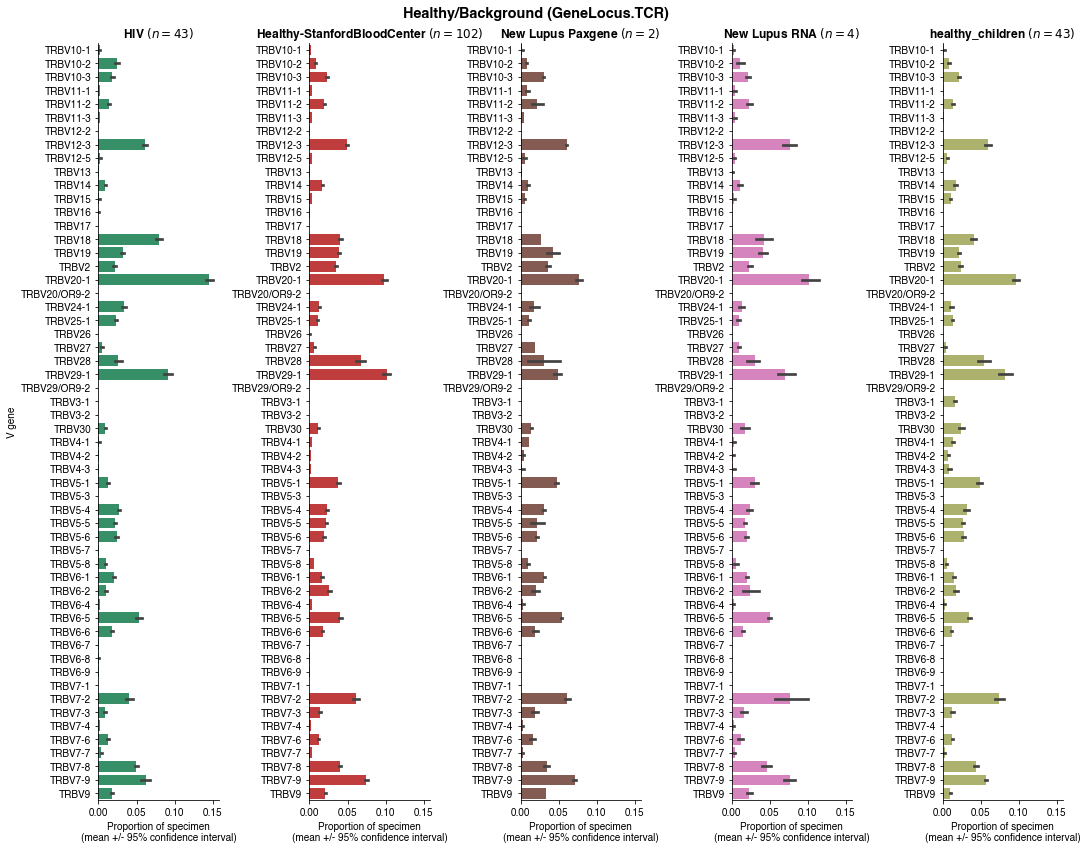

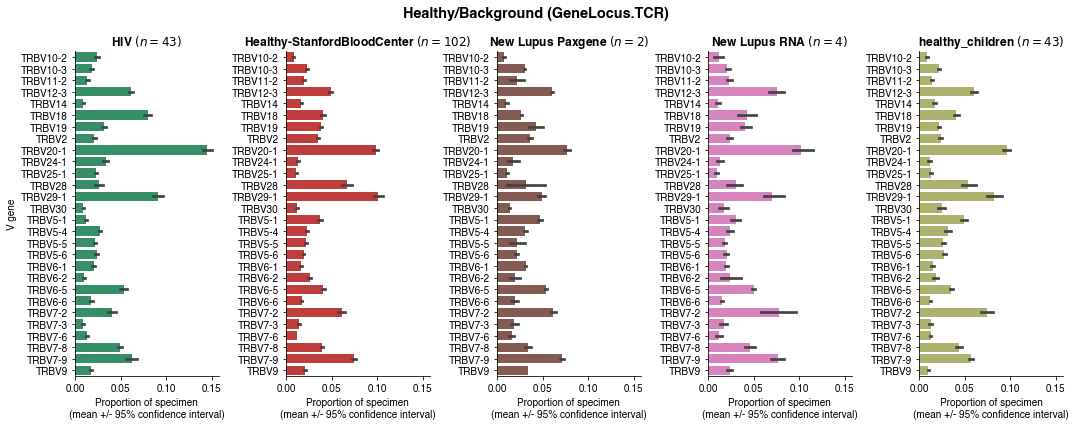

In [24]:
v_gene_use_proportions_by_specimen_and_study_name = {}
for gene_locus in config.gene_loci_used:
    v_gene_use_proportions_by_specimen_and_study_name[
        gene_locus
    ] = analyze_v_gene_proportions_by_subgroup(gene_locus, group_key="study_name")

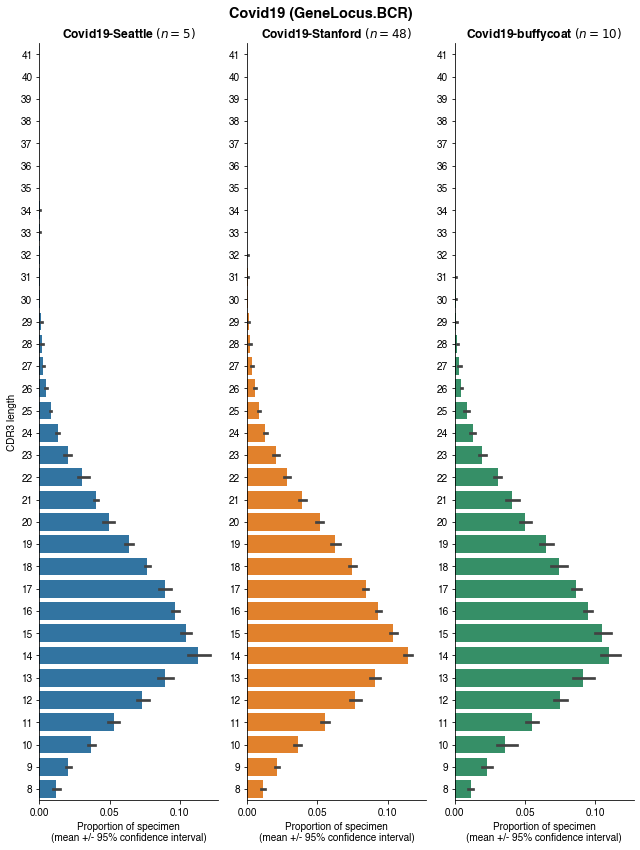

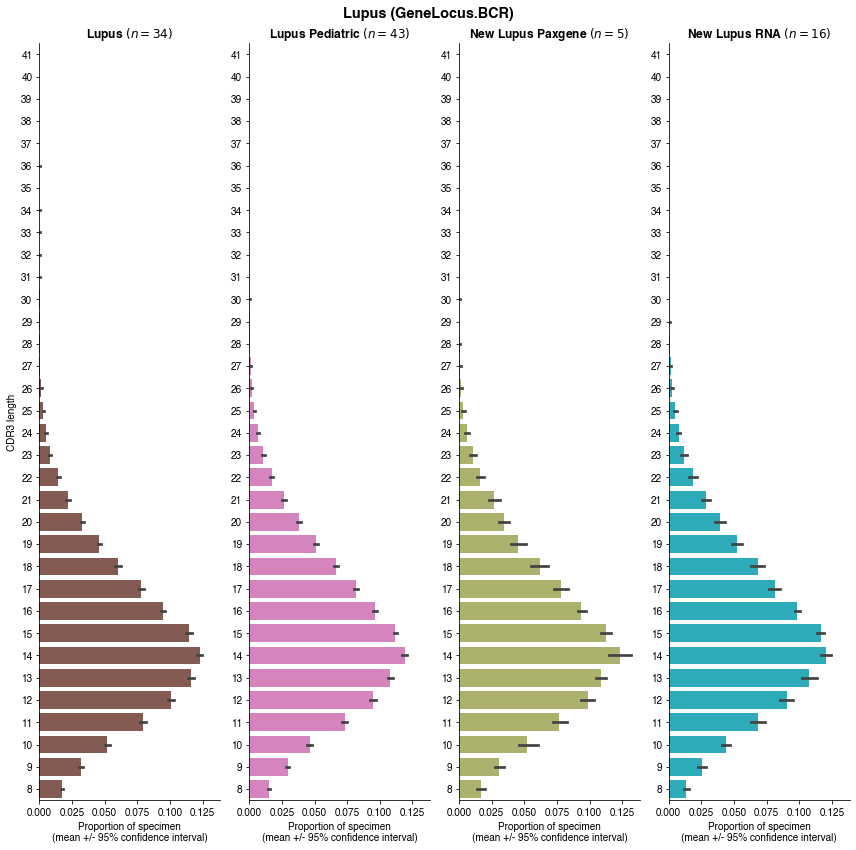

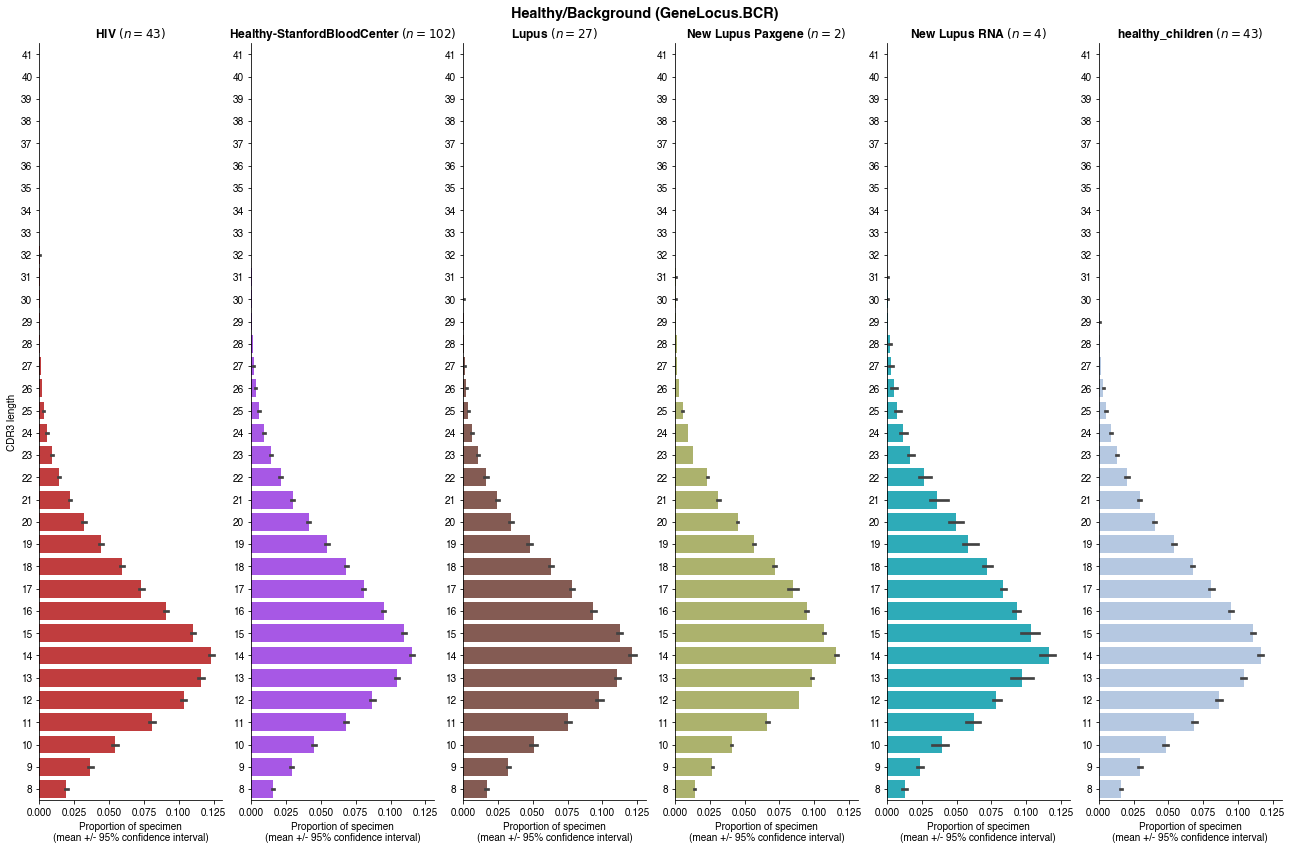

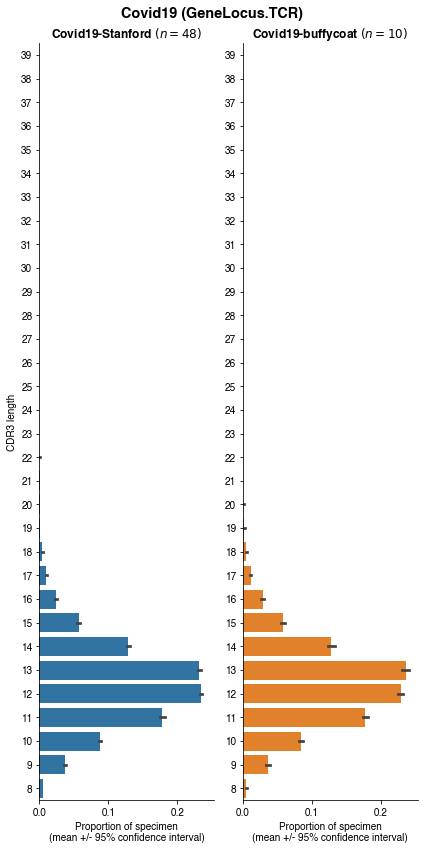

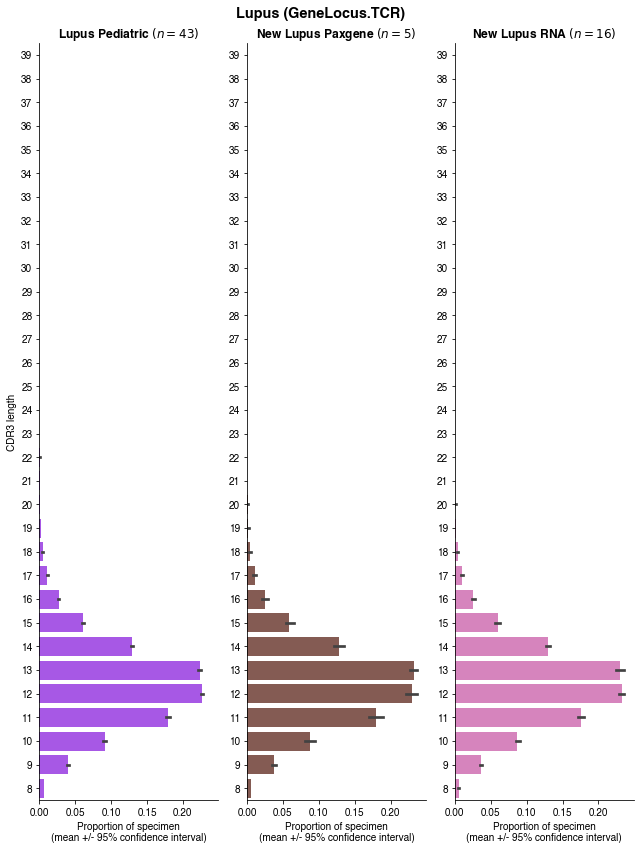

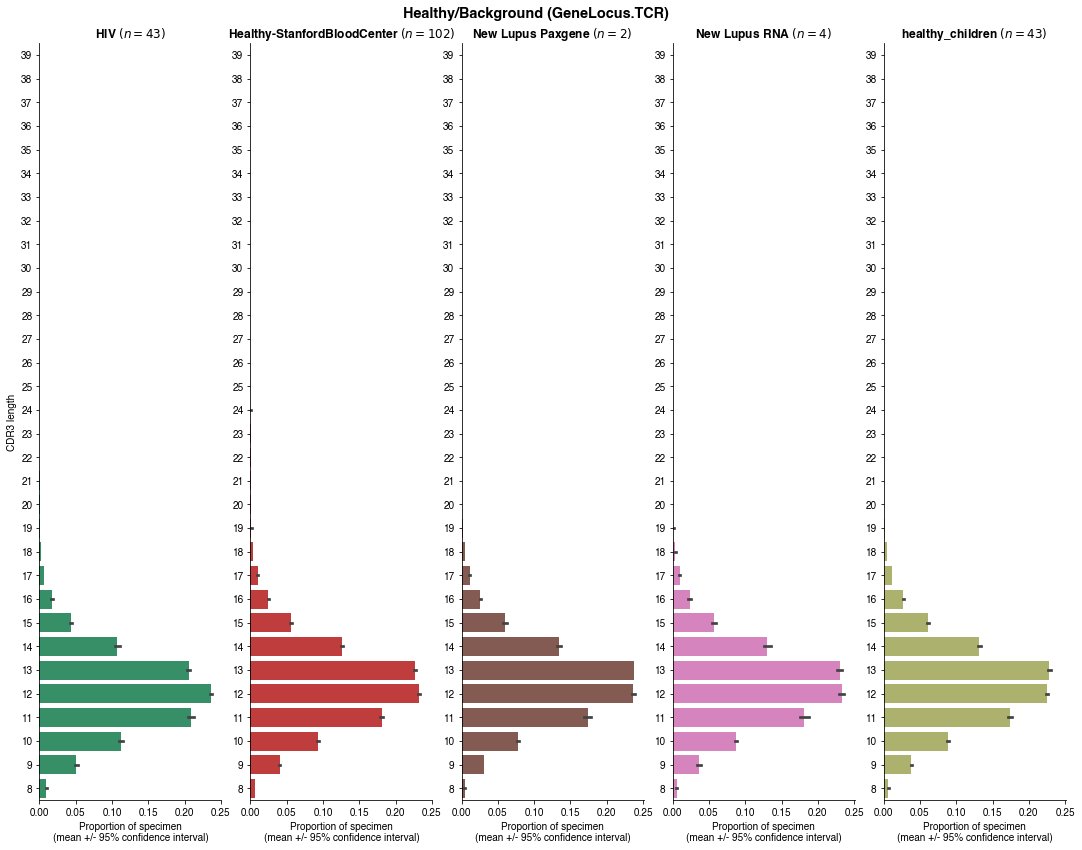

In [25]:
for gene_locus in config.gene_loci_used:
    analyze_cdr3_length_distribution_by_subgroup(gene_locus, group_key="study_name")

In [26]:
# Some TCR V genes are present in some study_names (batches) but not others
means = (
    v_gene_use_proportions_by_specimen_and_study_name[GeneLocus.TCR]
    .groupby(["disease", "study_name", "V gene"])["Proportion"]
    .mean()
)
means[means == 0.0]

disease             study_name                   V gene      
Covid19             Covid19-Stanford             TRBV17          0.0
                                                 TRBV26          0.0
                    Covid19-buffycoat            TRBV17          0.0
                                                 TRBV26          0.0
                                                 TRBV3-1         0.0
                                                 TRBV3-2         0.0
HIV                 HIV                          TRBV29/OR9-2    0.0
                                                 TRBV3-2         0.0
Healthy/Background  HIV                          TRBV17          0.0
                                                 TRBV29/OR9-2    0.0
                                                 TRBV3-2         0.0
                    Healthy-StanfordBloodCenter  TRBV17          0.0
                                                 TRBV3-2         0.0
                    New Lupus Paxgene    

In [27]:
# Some BCR V genes are present in some study_names (batches) but not others
means = (
    v_gene_use_proportions_by_specimen_and_study_name[GeneLocus.BCR]
    .groupby(["disease", "study_name", "V gene"])["Proportion"]
    .mean()
)
means[means == 0.0]

disease  study_name       V gene      
Covid19  Covid19-Seattle  IGHV1-68        0.0
                          IGHV1-69D       0.0
                          IGHV1/OR15-4    0.0
                          IGHV2-10        0.0
                          IGHV3-16        0.0
                                         ... 
Lupus    New Lupus RNA    IGHV3/OR16-8    0.0
                          IGHV7-81        0.0
                          VH3-41P         0.0
                          VH3-60P         0.0
                          VH7-27P         0.0
Name: Proportion, Length: 155, dtype: float64

In [28]:
all_expected_v_genes = helpers.all_observed_v_genes()
[(gl, lst.shape) for gl, lst in all_expected_v_genes.items()]

[(<GeneLocus.BCR: 1>, (85,)), (<GeneLocus.TCR: 2>, (57,))]

In [29]:
v_gene_use_proportions_by_specimen_and_study_name[GeneLocus.BCR][
    "V gene"
].unique().shape

(82,)

In [30]:
v_gene_use_proportions_by_specimen_and_study_name[GeneLocus.TCR][
    "V gene"
].unique().shape

(56,)

In [31]:
# Any BCR V genes in our entire parquet dataset after ETL step, but not in the plots above (i.e. not in peak timepoint test set?):
set.symmetric_difference(
    set(v_gene_use_proportions_by_specimen_and_study_name[GeneLocus.BCR]["V gene"]),
    all_expected_v_genes[GeneLocus.BCR],
)

{'IGHV1/OR15-5', 'IGHV1/OR21-1', 'IGHV3-25'}

In [32]:
# Any TCR V genes in our entire parquet dataset after ETL step, but not in the plots above (i.e. not in peak timepoint test set?):
set.symmetric_difference(
    set(v_gene_use_proportions_by_specimen_and_study_name[GeneLocus.TCR]["V gene"]),
    all_expected_v_genes[GeneLocus.TCR],
)

{'TRBV12-4'}

# Look at V gene usage and CDR3 lengths by Covid19 severity

No disease_severity group info for Lupus - skipping
No disease_severity group info for Lupus - skipping
No disease_severity group info for Healthy/Background - skipping
No disease_severity group info for Healthy/Background - skipping
No disease_severity group info for Lupus - skipping
No disease_severity group info for Lupus - skipping
No disease_severity group info for Healthy/Background - skipping
No disease_severity group info for Healthy/Background - skipping


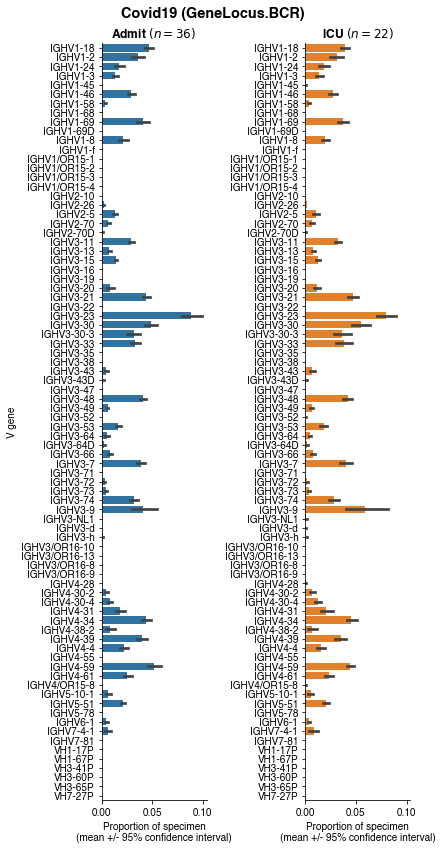

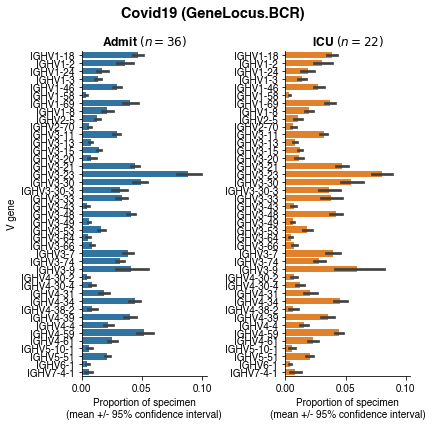

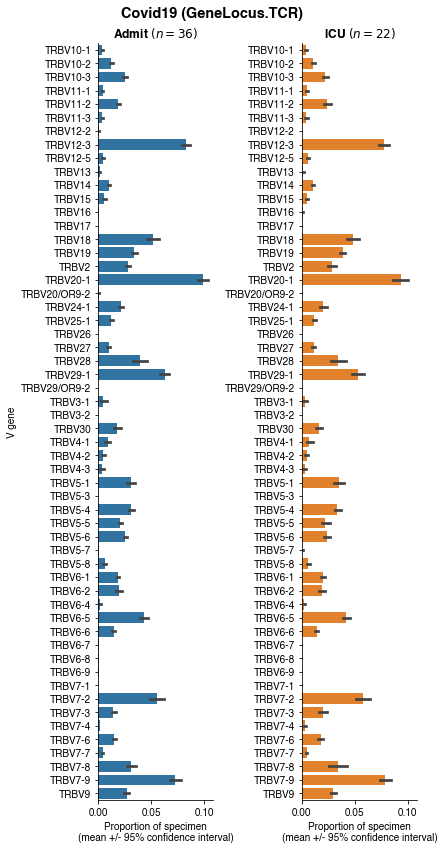

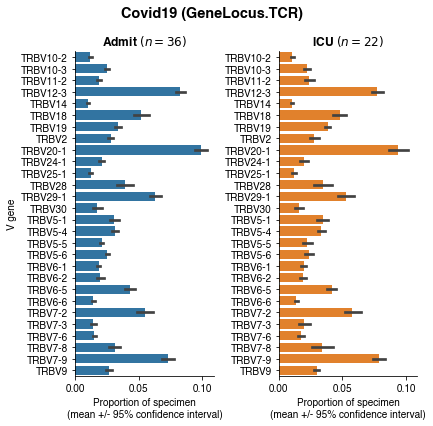

In [33]:
for gene_locus in config.gene_loci_used:
    analyze_v_gene_proportions_by_subgroup(gene_locus, group_key="disease_severity")

No disease_severity group info for Lupus - skipping
No disease_severity group info for Healthy/Background - skipping
No disease_severity group info for Lupus - skipping
No disease_severity group info for Healthy/Background - skipping


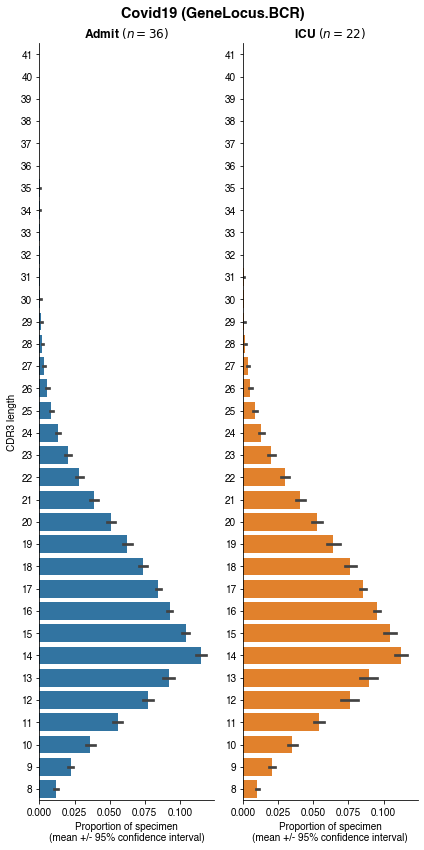

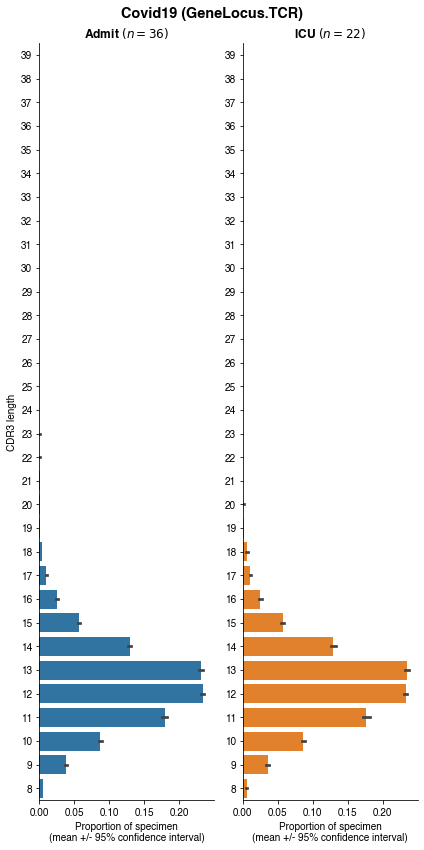

In [34]:
for gene_locus in config.gene_loci_used:
    analyze_cdr3_length_distribution_by_subgroup(
        gene_locus, group_key="disease_severity"
    )

# Plot V gene usage of each specimen on PCA/UMAP, and compare intra-disease batch distances vs inter-disease distances

Using cosine distance between V gene use proportion vectors per specimen (or mean across specimens in a disease-batch)

In [35]:
import anndata
import scanpy as sc
from scipy.spatial.distance import pdist, squareform

In [36]:
def plot_triangular_heatmap(
    df,
    cmap="Blues",
    colorbar_label="Distance",
    figsize=(8, 6),
    vmin=None,
    vmax=None,
    annot=True,
):

    with sns.axes_style("white"):
        # Based on https://seaborn.pydata.org/examples/many_pairwise_correlations.html

        fig, ax = plt.subplots(figsize=figsize)

        # Upper triangle mask
        triangle_mask = np.triu(np.ones_like(df, dtype=np.bool))

        sns.heatmap(
            df,
            cmap=cmap,
            # Draw the heatmap with the mask and correct aspect ratio
            mask=triangle_mask,
            vmin=vmin,
            vmax=vmax,
            square=True,
            cbar_kws={"shrink": 0.5, "label": colorbar_label},
            linewidths=0,
            ax=ax,
            # force all tick labels to be drawn
            xticklabels=True,
            yticklabels=True,
            annot=annot,
        )

        xticklabels = ax.set_xticklabels(
            ax.get_xticklabels(),
            rotation=0,
        )
        genetools.plots.wrap_tick_labels(
            ax, wrap_x_axis=True, wrap_y_axis=False, wrap_amount=10
        )

        return fig

In [37]:
# consider euclidean distance too?
def v_gene_use_plot_by_batch(
    gene_locus: GeneLocus, distance_metric="cosine", filter_v_genes=True
):
    output_dir, highres_output_dir = get_dirs(gene_locus)

    # Reload
    (
        specimen_v_gene_counts_df_test_only,
        v_gene_cols,
        v_gene_cols_filtered,
    ) = import_v_gene_counts(gene_locus=gene_locus)

    if filter_v_genes:
        # Use filtered set of V genes - ignore rare ones that may make specimens look artificially distinct
        v_gene_cols = v_gene_cols_filtered

    # Get V gene usage proportions per specimen
    v_gene_usage_proportions_by_specimen = pd.concat(
        [
            genetools.stats.normalize_rows(
                specimen_v_gene_counts_df_test_only[v_gene_cols]
            ),
            specimen_v_gene_counts_df_test_only["disease"],
        ],
        axis=1,
    )

    v_gene_usage_proportions_by_specimen_annot = genetools.helpers.merge_into_left(
        v_gene_usage_proportions_by_specimen[v_gene_cols],
        extra_specimen_metadata.set_index("specimen_label"),
    )
    assert (
        v_gene_usage_proportions_by_specimen_annot.shape[0]
        == v_gene_usage_proportions_by_specimen.shape[0]
    )
    assert not v_gene_usage_proportions_by_specimen_annot["disease"].isna().any()
    assert not v_gene_usage_proportions_by_specimen_annot["study_name"].isna().any()

    ## PCA and UMAP of V gene use by specimen, colored by disease + batch
    adata_vgene_use = anndata.AnnData(
        X=v_gene_usage_proportions_by_specimen_annot[v_gene_cols],
        obs=v_gene_usage_proportions_by_specimen_annot[
            v_gene_usage_proportions_by_specimen_annot.columns[
                ~v_gene_usage_proportions_by_specimen_annot.columns.isin(v_gene_cols)
            ]
        ],
    )

    adata_vgene_use.obs["disease_and_batch"] = (
        adata_vgene_use.obs["disease"] + " - " + adata_vgene_use.obs["study_name"]
    )

    adata_vgene_use.raw = adata_vgene_use
    sc.pp.scale(adata_vgene_use)
    sc.pp.pca(adata_vgene_use)
    sc.pp.neighbors(adata_vgene_use, metric=distance_metric)
    sc.tl.umap(adata_vgene_use)

    fig_pca = sc.pl.pca(
        adata_vgene_use,
        color="disease_and_batch",
        alpha=0.5,
        return_fig=True,
        title=f"V gene proportions PCA by disease+batch\n{gene_locus}",
    )
    genetools.plots.savefig(
        fig_pca,
        highres_output_dir
        / f"v_gene_proportions_by_specimen.pca.color_by_disease_batch.png",
        dpi=300,
    )
    fig_umap = sc.pl.umap(
        adata_vgene_use,
        color="disease_and_batch",
        alpha=0.5,
        return_fig=True,
        title=f"V gene proportions UMAP by disease+batch\n{gene_locus}",
    )
    genetools.plots.savefig(
        fig_umap,
        highres_output_dir
        / f"v_gene_proportions_by_specimen.umap.color_by_disease_batch.png",
        dpi=300,
    )

    ## Heatmap of pairwise distance between means of each disease+batch category
    means = v_gene_usage_proportions_by_specimen_annot.groupby(
        ["disease", "study_name"]
    )[v_gene_cols].mean()
    # distance matrix
    dist_mat = pd.DataFrame(
        squareform(pdist(means, metric=distance_metric)),
        # combine disease and study name multiindex
        index=means.index.map(" - ".join),
        columns=means.index.map(" - ".join),
    )
    #     ax = sns.heatmap(dist_mat, cmap="Blues", square=True)
    #     ax.set_xticklabels(
    #         ax.get_xticklabels(), rotation=60, size=12, horizontalalignment="right"
    #     )

    fig_means = plot_triangular_heatmap(dist_mat, vmin=0)
    plt.title(
        f"{distance_metric} distance between disease+batch mean V gene usage\n{gene_locus}"
    )
    genetools.plots.savefig(
        fig_means,
        highres_output_dir
        / f"v_gene_proportions_by_specimen.means_by_disease_batch.distance_heatmap.png",
        dpi=300,
    )

    ## Repeat with median to be resilient to outliers:
    # Heatmap of pairwise distance between medians of each disease+batch category
    medians = v_gene_usage_proportions_by_specimen_annot.groupby(
        ["disease", "study_name"]
    )[v_gene_cols].median()
    # distance matrix
    dist_mat = pd.DataFrame(
        squareform(pdist(medians, metric=distance_metric)),
        # combine disease and study name multiindex
        index=medians.index.map(" - ".join),
        columns=medians.index.map(" - ".join),
    )
    fig_medians = plot_triangular_heatmap(dist_mat, vmin=0)
    plt.title(
        f"{distance_metric} distance between disease+batch median V gene usage\n{gene_locus}"
    )
    genetools.plots.savefig(
        fig_medians,
        highres_output_dir
        / f"v_gene_proportions_by_specimen.medians_by_disease_batch.distance_heatmap.png",
        dpi=300,
    )

    ## Get pairwise distances between specimens. Plot as boxplots grouped by specimen info.

    # Sort order so that when we construct pairwise distance dataframe and take upper triangle, we are left with all comparisons as A vs B only, not some as A vs B and others as B vs A.
    v_gene_usage_proportions_by_specimen_annot.sort_values(
        ["disease", "study_name"], inplace=True
    )

    new_index = pd.MultiIndex.from_frame(
        v_gene_usage_proportions_by_specimen_annot.reset_index()[
            ["specimen_label", "disease", "study_name"]
        ]
    )
    all_dists = pd.DataFrame(
        squareform(
            pdist(
                v_gene_usage_proportions_by_specimen_annot[v_gene_cols],
                metric=distance_metric,
            )
        ),
        index=new_index.rename([f"{name}_1" for name in new_index.names]),
        columns=new_index.rename([f"{name}_2" for name in new_index.names]),
    )

    # Make sure no nans to begin with, because we're going to set lower triangle to nan and drop all nans.
    assert not all_dists.isna().any().any()

    # Upper triangle mask to remove symmetric duplicate entries
    upper_triangle_mask = np.triu(np.ones_like(all_dists, dtype=bool))
    all_dists = all_dists.where(upper_triangle_mask)

    # Move to long form
    # Special stack logic to handle multiindex
    # Also drop N/As
    all_dists = all_dists.stack(
        level=list(range(all_dists.columns.nlevels)), dropna=True
    ).reset_index(name="distance")

    all_dists["comparison"] = (
        all_dists["disease_1"]
        + " - "
        + all_dists["study_name_1"]
        + " vs "
        + all_dists["disease_2"]
        + " - "
        + all_dists["study_name_2"]
    )

    fig_boxplot, ax = plt.subplots(figsize=(8, 6))
    sns.boxplot(
        data=all_dists,
        x="distance",
        y="comparison",
        order=all_dists.groupby("comparison")["distance"].median().sort_values().index,
        ax=ax,
    )
    ax.set_xlabel(f"{distance_metric} distance")
    ax.set_title(
        f"Pairwise distances between specimens V gene use proportions\n{gene_locus}"
    )
    genetools.plots.savefig(
        fig_boxplot,
        highres_output_dir
        / f"v_gene_proportions_by_specimen.pairwise_distances.boxplot_by_disease_batch.png",
        dpi=300,
    )

    return adata_vgene_use

2023-01-08 22:27:01,056 - py.warnings - WARNING - /tmp/ipykernel_3160280/2102546399.py:41: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  adata_vgene_use = anndata.AnnData(

2023-01-08 22:27:37,491 - anndata - INFO - ... storing 'participant_label' as categorical
2023-01-08 22:27:37,495 - anndata - INFO - ... storing 'disease' as categorical
2023-01-08 22:27:37,498 - anndata - INFO - ... storing 'specimen_time_point' as categorical
2023-01-08 22:27:37,500 - anndata - INFO - ... storing 'participant_description' as categorical
2023-01-08 22:27:37,502 - anndata - INFO - ... storing 'cohort' as categorical
2023-01-08 22:27:37,504 - anndata - INFO - ... storing 'study_name' as categorical
2023-01-08 22:27:37,507 - anndata - INFO - ... storing 'disease_subtype' as categorical
2023-01-08 22:

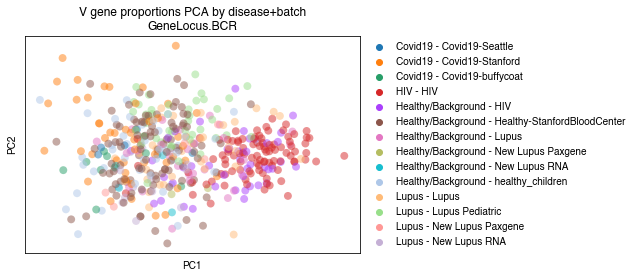

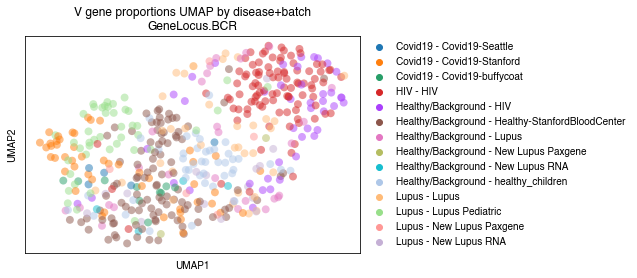

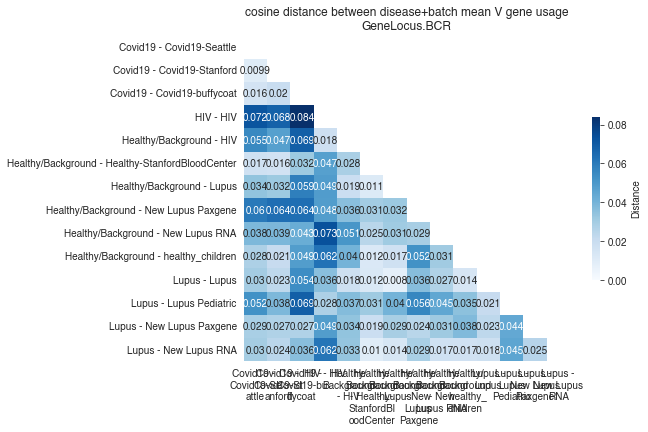

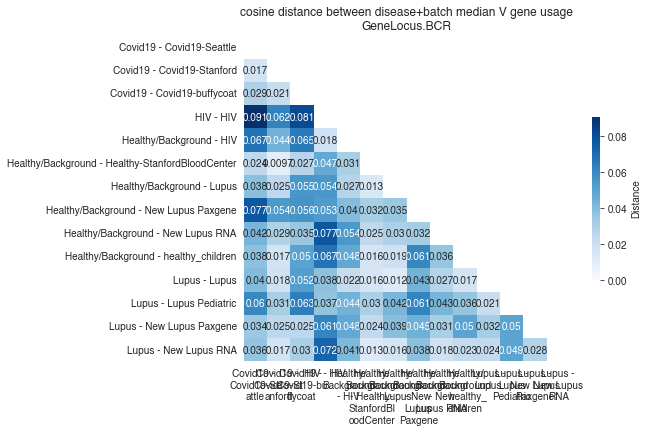

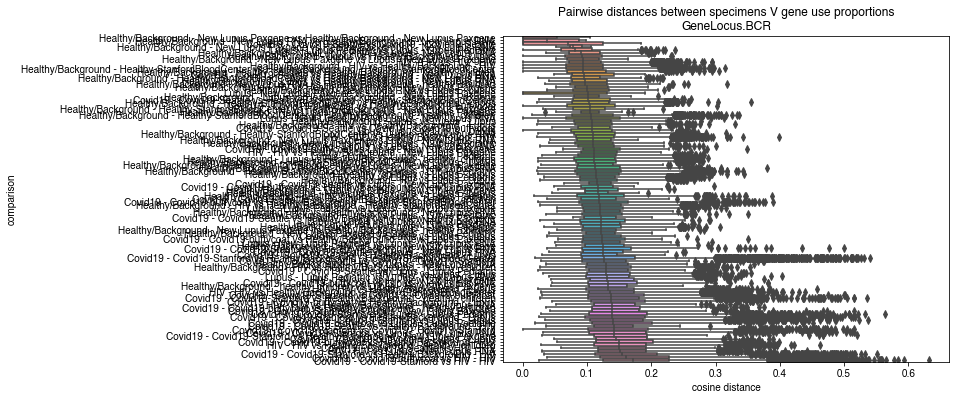

In [38]:
adata_vgene_use_bcr = v_gene_use_plot_by_batch(gene_locus=GeneLocus.BCR)

2023-01-08 22:27:50,150 - py.warnings - WARNING - /tmp/ipykernel_3160280/2102546399.py:41: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  adata_vgene_use = anndata.AnnData(

2023-01-08 22:27:52,174 - anndata - INFO - ... storing 'participant_label' as categorical
2023-01-08 22:27:52,177 - anndata - INFO - ... storing 'disease' as categorical
2023-01-08 22:27:52,179 - anndata - INFO - ... storing 'specimen_time_point' as categorical
2023-01-08 22:27:52,181 - anndata - INFO - ... storing 'participant_description' as categorical
2023-01-08 22:27:52,184 - anndata - INFO - ... storing 'cohort' as categorical
2023-01-08 22:27:52,186 - anndata - INFO - ... storing 'study_name' as categorical
2023-01-08 22:27:52,188 - anndata - INFO - ... storing 'disease_subtype' as categorical
2023-01-08 22:

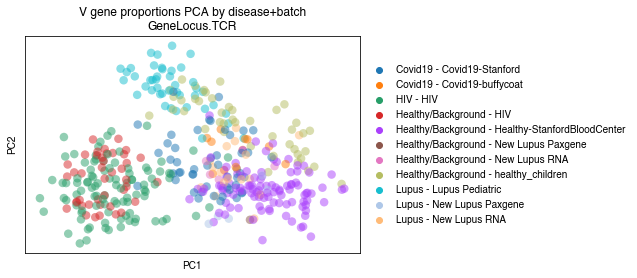

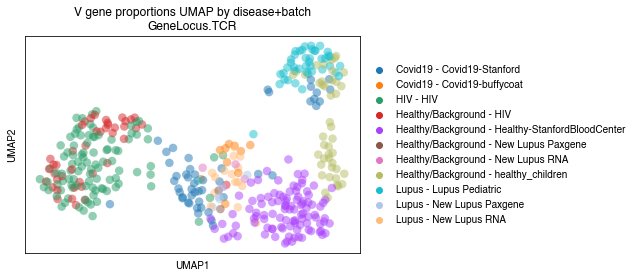

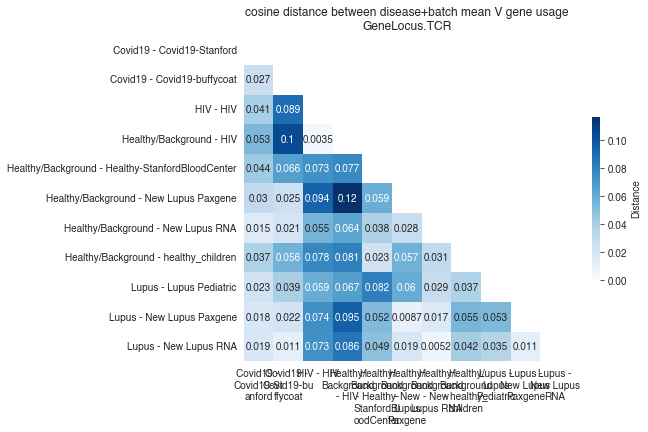

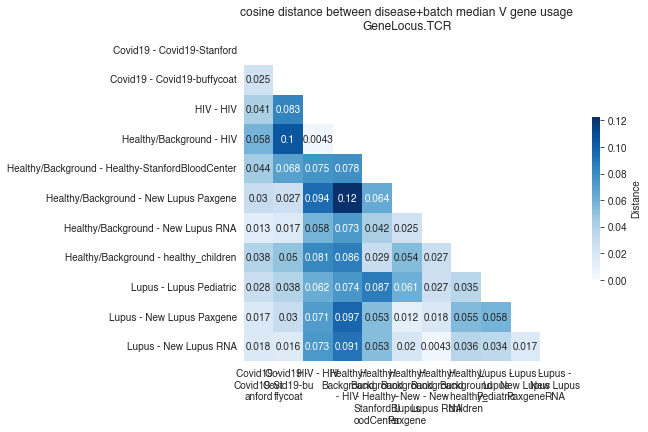

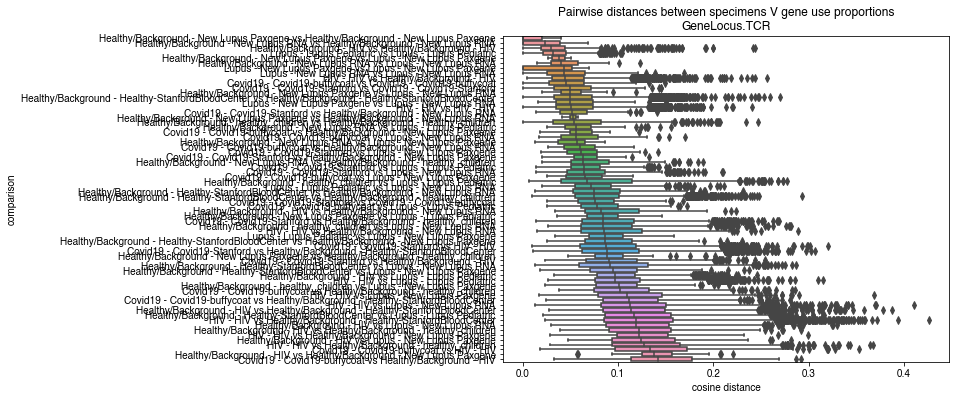

In [39]:
adata_vgene_use_tcr = v_gene_use_plot_by_batch(gene_locus=GeneLocus.TCR)

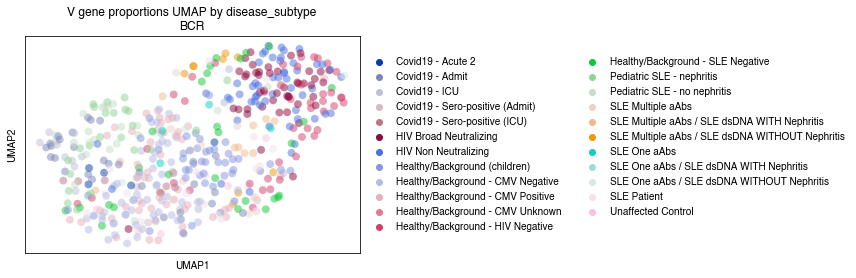

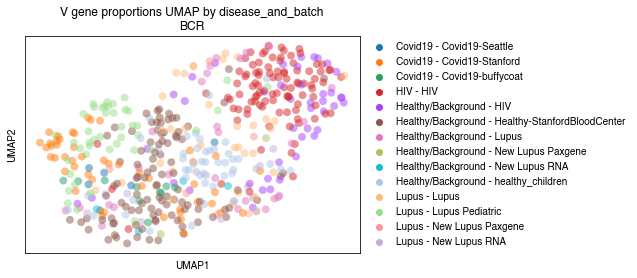

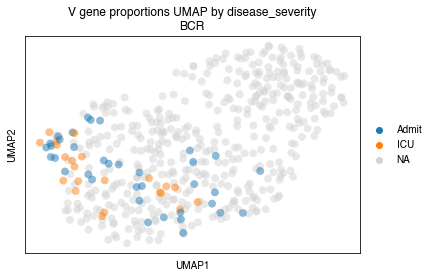

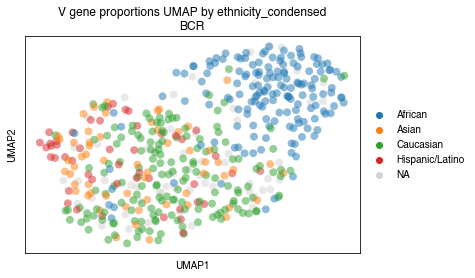

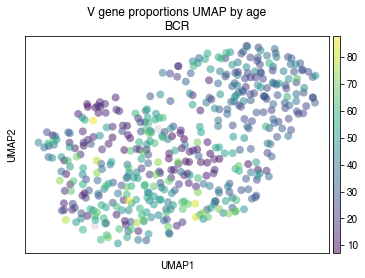

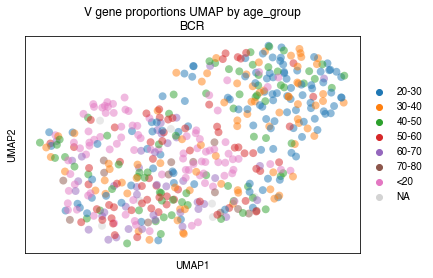

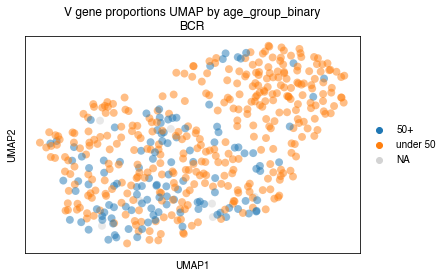

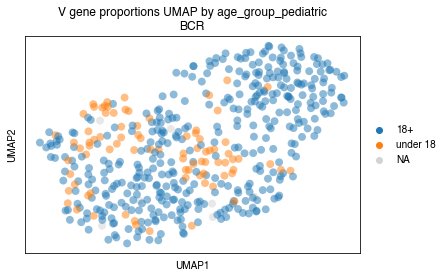

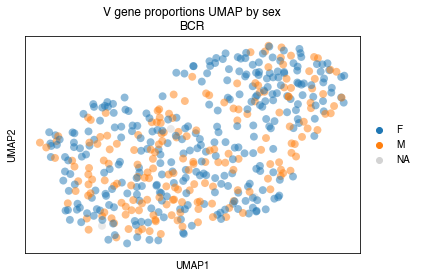

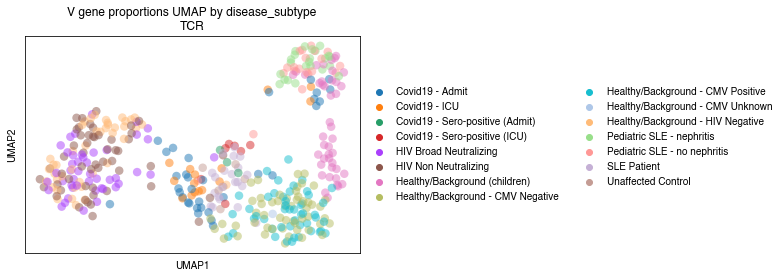

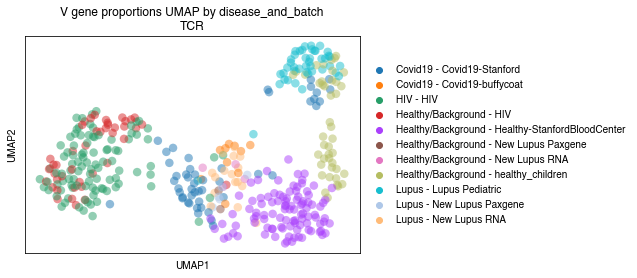

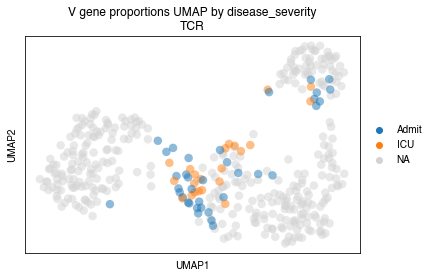

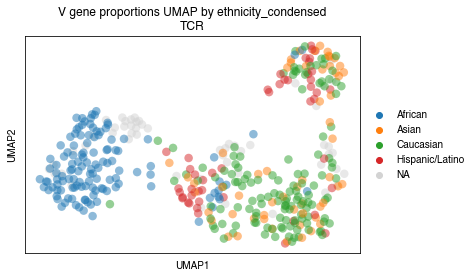

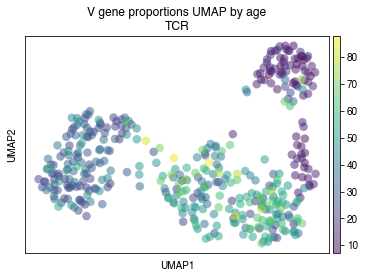

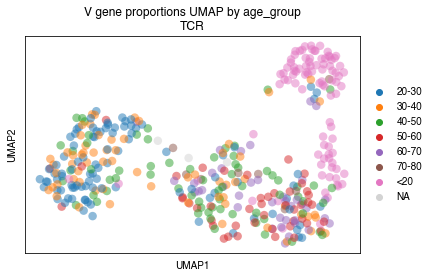

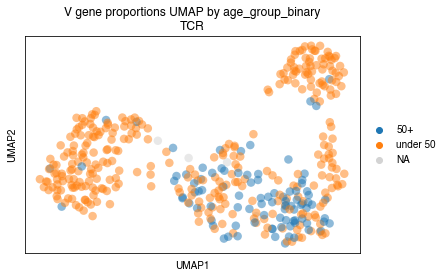

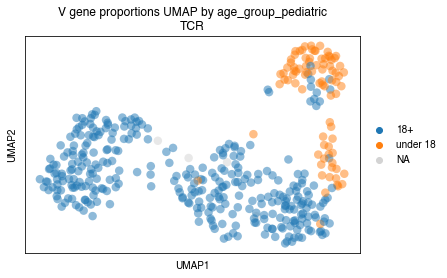

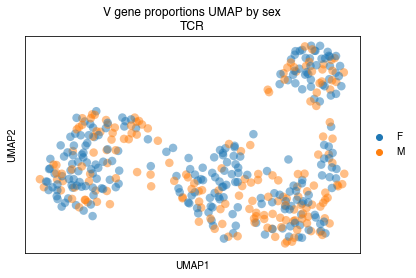

In [40]:
for gene_locus, adata_vgene_use_single_locus in [
    (GeneLocus.BCR, adata_vgene_use_bcr),
    (GeneLocus.TCR, adata_vgene_use_tcr),
]:
    output_dir, highres_output_dir = get_dirs(gene_locus)
    for color in [
        "disease_subtype",
        "disease_and_batch",
        "disease_severity",
        "ethnicity_condensed",
        "age",
        "age_group",
        "age_group_binary",
        "age_group_pediatric",
        "sex",
    ]:
        fig_umap = sc.pl.umap(
            adata_vgene_use_single_locus,
            color=color,
            alpha=0.5,
            return_fig=True,
            title=f"V gene proportions UMAP by {color}\n{gene_locus.name}",
        )
        genetools.plots.savefig(
            fig_umap,
            highres_output_dir
            / f"v_gene_proportions_by_specimen.umap.color_by_variable.{color}.png",
            dpi=300,
        )